# DNSC 6211 Programming For Analytics Final Group Project

### Group 9: Shuwei Deng, Chengquan Guan, Mingqi Liu, Jiwei Zeng

Because the file of database is given, we choose file of sql to load data more effectively and efficiently.

To use the file of sql, it is necessary to establish a database in localhost or AWS at first. After that, we used workbench to load file of sql into the database we established.

In [6]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Connecting to the database

In [12]:
mydb = pymysql.connect(user='Lan', password='12345678',
                               host='myyelpdb.caenuubtjpww.us-east-1.rds.amazonaws.com',port=3309,database='yelp_db')

In [7]:
mydb = pymysql.connect(user='root', password='G42955089',
                               host='localhost',database='yelp_db')

In [4]:
cursor = mydb.cursor()

### The map of count of business and average stars of each states in different states
First of all, we aim to take a look at locations of business in our data.

In [7]:
sql='''
    SELECT state, COUNT(state) AS COUNT, ROUND(AVG(stars),2) AS mean
    FROM business
    GROUP BY state
    ORDER BY COUNT DESC;
    '''

In [8]:
state = pd.read_sql(sql,mydb)

In [9]:
state.head()

state  COUNT  mean
0    AZ  47376  3.73
1    NV  30571  3.71
2    ON  26520  3.45
3    NC  11299  3.58
4    OH  10930  3.57

For visualization, we use plotly to draw a map of location of our business.

In [50]:
import plotly
import plotly.graph_objs as go

In [10]:
for col in state.columns:
    state[col] = state[col].astype(str)

In [11]:
#To show average stars of business in map
state['text']=state['state'] +  '<br>' \
              +'Average of stars: ' + state['mean']

In [12]:
#To custome the color of our map
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

In [13]:
trc = dict(
        type = 'choropleth',
        colorscale = scl,
        locations = state['state'],
        z = state['COUNT'].astype(float),
        text = state['text'],
        locationmode = 'USA-states',
          marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) )) 

In [14]:
lyt = dict(
        title = 'Num. of Business By State',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)')
             )

In [15]:
plotly.offline.init_notebook_mode(connected=True)

In [16]:
map=go.Figure(data=[trc],layout=lyt)
plotly.offline.iplot(map)

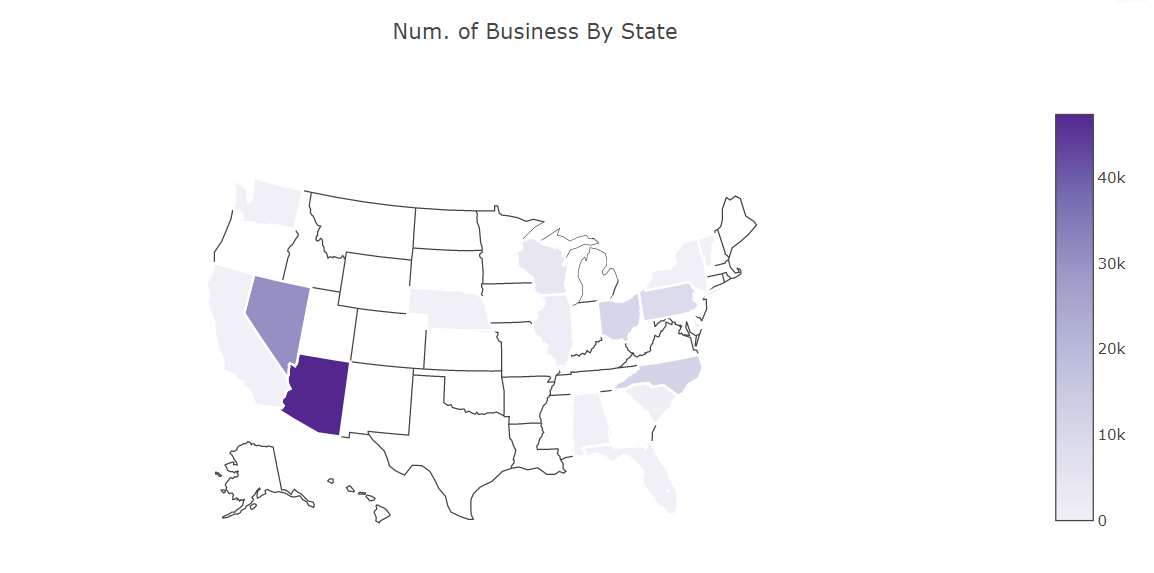

The map above shows that most of our data are based on business in West USA. Therefore, we choose restaurants in the west part as our story background and we would use data in west part which is more supportive.

### Create table include the data of restaurant in the west part of US.
Focusing on the performance of restaurants in west part of US, we created a table named restaurants only with data of restaurants in the west, for convinience of later query.

In [15]:
sql='''
DROP TABLE IF EXISTS restaurants;
'''
cursor.execute(sql)

0

In [16]:
sql='''
CREATE TABLE restaurants( 
        id VARCHAR(50) PRIMARY KEY,
        name VARCHAR(250),
        city VARCHAR(50) ,
        state VARCHAR(10) ,
        postal_code VARCHAR(250),
        latitude FLOAT,
        longitude FLOAT,
        stars FLOAT NOT NULL,
        review_count INT ,
        is_open INT 
        )
'''
cursor.execute(sql)

0

In [17]:
sql='''
INSERT INTO restaurants  
   SELECT id, name, city, state,postal_code,latitude, longitude, stars, review_count,is_open  
   FROM business  
   JOIN category  
   ON id=category.business_id  
   AND category="Restaurants"
   AND (business.state='AZ' or business.state='NV' or business.state='CA' or business.state='WA');
'''
cursor.execute(sql)

17104

In [18]:
mydb.commit()

In [32]:
sql = '''
    SELECT COUNT(*) FROM restaurants;
'''

In [33]:
res = pd.read_sql(sql,mydb)

In [34]:
res

COUNT(*)
0     17104

### The correlations between Stars and check-in, stars and review_count and review_count and check_in.
In our discussion, it was expected that higher stars of restaurants would attract more customers. Therefore, the data and plot below is to verify our expectation.

In [6]:
data = pd.read_sql('select stars, count, review_count from restaurants join checkin on restaurants.id=checkin.business_id;', mydb) 

In [7]:
import matplotlib.pyplot as plt

In [8]:
from matplotlib.pyplot import *

In [9]:
import seaborn as sns

In [10]:
pd.plotting.scatter_matrix(data.loc[:, ["stars","count","review_count"]], diagonal="kde")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013554BC8B00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001355749E438>]], dtype=object)

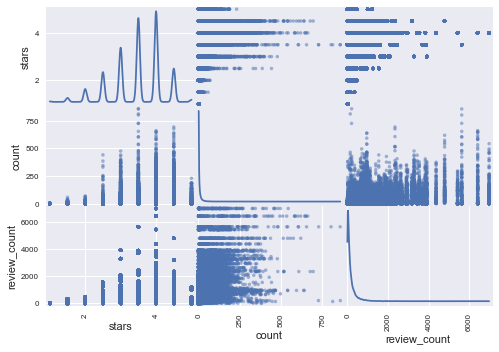

In [11]:
plt.figure(figsize = [12,12])

plt.show()

In [36]:
# To calculate the correlation between every two variables
corr = data.corr(method="pearson")
sns.heatmap(corr)

In [37]:
corr

stars     count  review_count
stars         1.000000  0.153470      0.215748
count         0.153470  1.000000      0.529276
review_count  0.215748  0.529276      1.000000

In [38]:
sns.heatmap(corr)

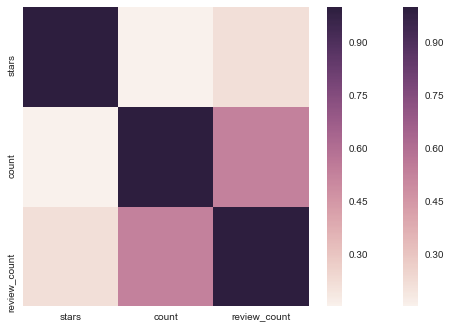

In [39]:
plt.show()

So basically, the first graph is showing us the relationship between each two of the variables like starts and count, count and review count, and stars and review count. For stars and count, as we can see from the graph, the majority star ratings are distributed at 2.5 to 4.5 stars. Among which, 3.5-star has the greatest rating counts. Almost the same thing happens to the relationship between stars and review_count, the majority reviews fall into range of 3 to 4.5, 4-star has the greatest review counts. For relationship between counts and review-count, review-counts under 4,000 are somehow evenly distributed, when revew-count exceed 4,000 some gaps appear.

From the correlation heatmap, we can see that the darker the color, the stronger the lorrelation. There are 4 very light squares in the graph, stars and count has the lighter color, which means they have the weakest relationship of 0.15347. Stars and review-count has a little bit stronger relationship of 0.215748. Count and review-count has the strongest relationship of 0.529276.

Though the correlation between stars and checkin count is not high, most restaurants with high checkin count or review count are high stars, which shows importance of high stars.

### Bar Chart of business's categories and its number (focusing on restaurants)

In this part, the bar chart would be used to explore the cetegories of restaurants and we wonder what kinds of categories account for larger proportion. 

In [26]:
sql='''
    SELECT category,COUNT(*) AS Count
    FROM category
    JOIN restaurants 
    ON category.business_id = restaurants .id
    GROUP BY category
    ORDER BY Count DESC
    LIMIT 20;
    '''

In [27]:
cate_count = pd.read_sql(sql,mydb)

In [28]:
# The first row is restaurants so we delete it.
cate_count=cate_count[1:]

In [29]:
import numpy as np

In [30]:
plt.clf()
fig = plt.figure(figsize=[20,8])
ax2=fig.add_subplot(1,1,1)
ax2.set(title = 'Number Of Categories of Business',xlabel='Categories',ylabel='Number')
# Draw the bar chart
_ = ax2.bar(np.arange(len(cate_count)), height=np.array(cate_count['Count']),width=0.5,color='lightblue')
# Set the X label
ax2.set_xticks(np.arange(len(cate_count)))
ax2.set_xticklabels(cate_count['category'])
#Rotate the X label
for tick in ax2.get_xticklabels():
    tick.set_rotation(30)

The chart below indicates that top 5 categories are Food, Fast Food, Mexican, American(Traditional) and Sandwiches. In fact, our groups also feels that there are many restaurants of these cateories around us.

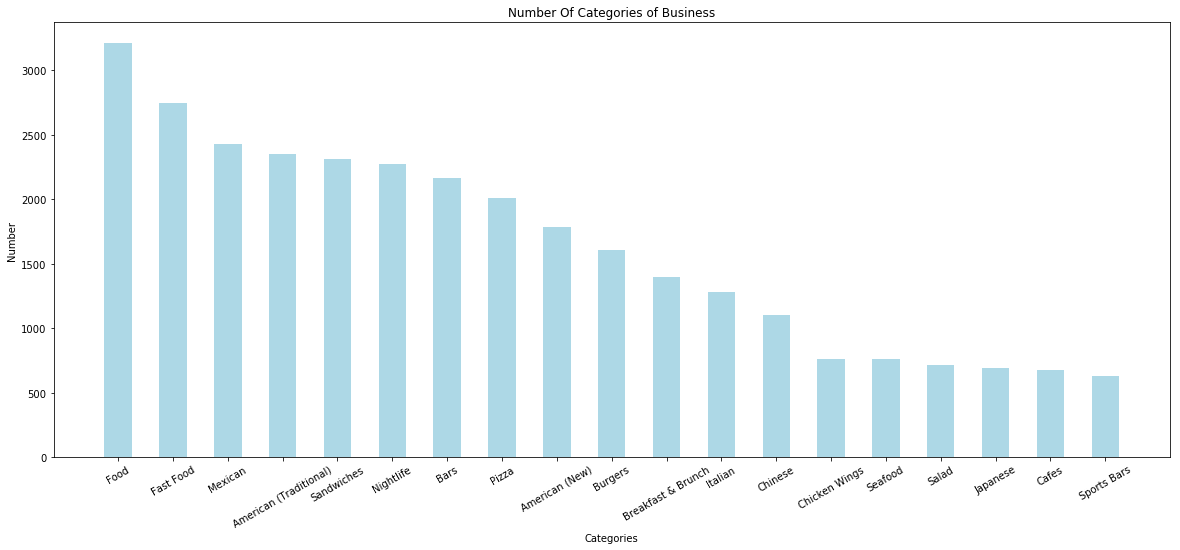

In [31]:
plt.show()

### Number of reviews of restaurants in West USA 

In [17]:
#put the data into pandas dataframe
restaurant = pd.read_sql('select * from restaurants',mydb)

In [18]:
#prepare for the count
first = 0 #first means the first segment for the pie chart.
second = 0
third = 0
forth = 0
fifth = 0
#start to count
for j in range(0,17103):
    if restaurant.review_count[j] <= 30:
        first = first + 1
    elif restaurant.review_count[j] <= 100:
            second = second + 1
    elif restaurant.review_count[j] <= 250:
            third = third + 1
    elif restaurant.review_count[j] <= 500:
            forth = forth + 1
    else:
        fifth = fifth + 1

In [19]:
#use plotly to do offline drawing at notebook
plotly.offline.init_notebook_mode(connected=True)
#create labels and corresponding values
labels = ['less than 30','30-100','100-250','250-500','more than 500']
values = [first,second,third,forth,fifth]
#draw the pie chart and adding layout, which in this pie chart, title is enough
trace = go.Pie(labels=labels, values=values)
layout = go.Layout(title='Number of reviews for all restaurants in West USA')
#go to the entire figure and show the plot
fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig)

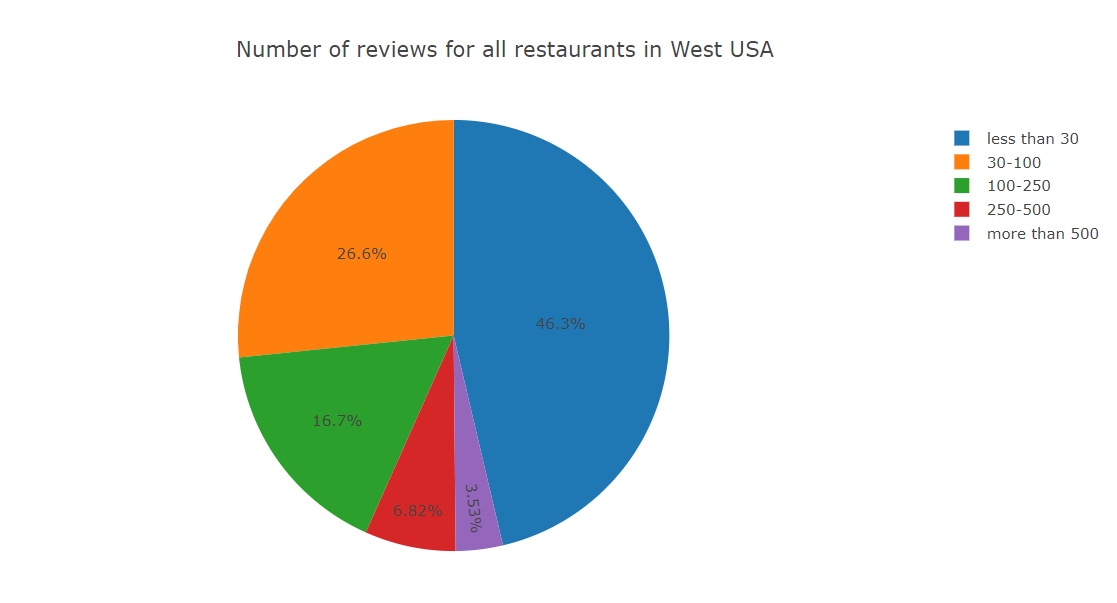

In [53]:
plt.clf()
fig = plt.figure(figsize=[10,8])
ax1=fig.add_subplot(1,1,1)
ax1.set(title = 'Number Of Reviews Business Received',xlabel='Count of Review',ylabel='Number')
ax1.set_xlim(0,200)
# Calculate the mean of number of reviews of business received.
ax1.axvline(restaurant['review_count'].mean(),color='r',linestyle='dashed')
_ = ax1.hist(restaurant['review_count'].values,bins=600,color='lightblue',edgecolor='black',alpha=0.3)

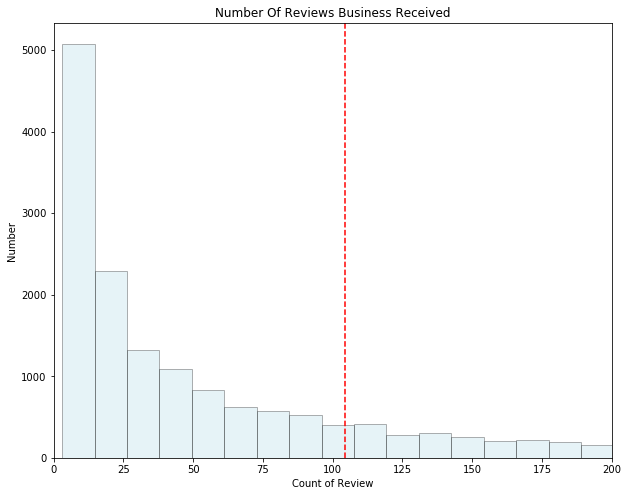

In [55]:
plt.show()

Apparently, most of the restaurants have number of review less than 30 or from 30 to 100. Only 3.53% of the restaurants are popular enough to receive over 500 reviews from customers.

### The number of reviews of different stars 

In this part, we will take a look at numbers of reviews of differents stars.

In [12]:
sql='''
    SELECT review.stars,COUNT(*) AS Count
    FROM review
    JOIN restaurants 
    ON review.business_id = restaurants.id
    GROUP BY review.stars
    ORDER BY review.stars DESC;
    '''

In [13]:
stars_r=pd.read_sql(sql,mydb)

In [36]:
stars_r

stars   Count
0      5  717789
1      4  463297
2      3  231117
3      2  168116
4      1  206864

In [16]:
plt.clf()
fig = plt.figure(figsize=[8,8])
ax3=fig.add_subplot(1,1,1)
ax3.set(title = 'Stars Of Reviews',xlabel='Stars',ylabel='No. Of Reviews')
_ = ax3.bar(np.arange(len(stars_r)), height=np.array(stars_r['Count']),color='lightblue',width=0.3)
# Set the X label
ax3.set_xticks(np.arange(len(stars_r)))
ax3.set_xticklabels(stars_r['stars'])

The bar charts below shows that most of reviews are of 5 stars or 4 stars. Reviews of less than 4 stars are less.

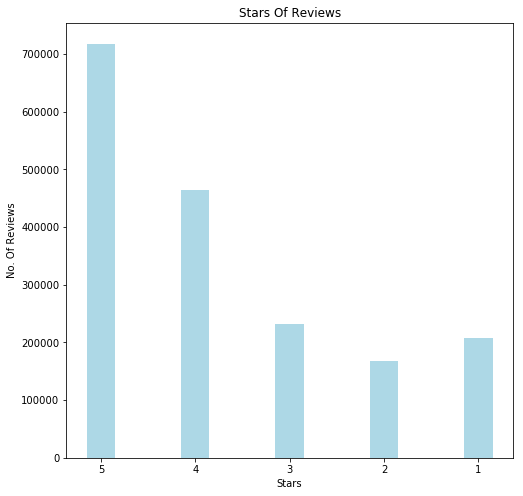

In [17]:
plt.show()

### Histogram of average stars of users

In [8]:
sql='''
    SELECT average_stars
    FROM user;
    '''

In [9]:
stars_user = pd.read_sql(sql,mydb)

In [10]:
plt.clf()
fig = plt.figure(figsize=[10,10])
ax5=fig.add_subplot(1,1,1)
ax5.set(title = "Histogram Of Users' average stars",xlabel='average stars',ylabel='Number')
ax5.set_xlim(1,5)
# Calculate the average stars of users.
ax5.axvline(stars_user['average_stars'].mean(),color='r',linestyle='dashed')
_ = ax5.hist(stars_user['average_stars'].values,bins=50,color='lightblue',edgecolor='black',alpha=0.3)

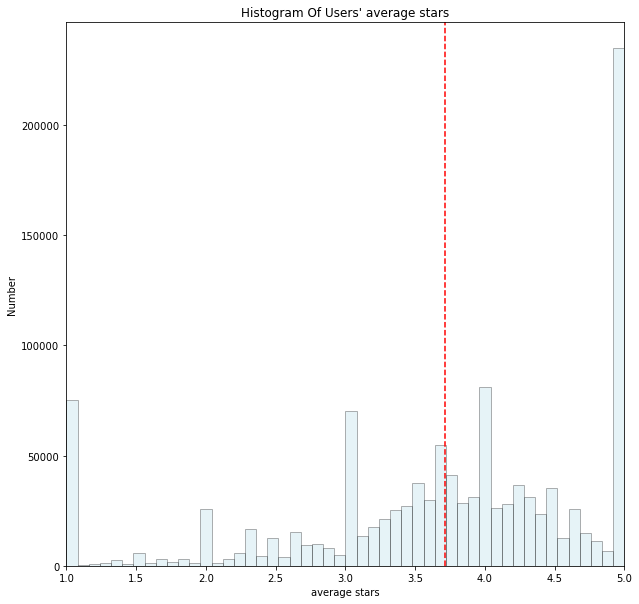

In [11]:
plt.show()

Based on two graphs above, we can conclude that most users are willing to rate in high stars, as long as restaurants could satisfy their requirements.

### Number of reviews for all users in USA

In [18]:
reviewuser = pd.read_sql('select id, review_count from user', mydb) 

In [21]:
#prepare for the count
first1 = 0 #first1 means the first segment for the pie chart.
second2 = 0
third3 = 0
forth4 = 0
fifth5 = 0
#start the count
for j in range(0,1183361):
    if reviewuser.review_count[j] <= 5:
        first1 = first1 + 1
    elif reviewuser.review_count[j] <= 15:
        second2 = second2 + 1
    elif reviewuser.review_count[j] <= 50:
        third3 = third3 + 1
    elif reviewuser.review_count[j] <= 100:
        forth4 = forth4 + 1
    else:
        fifth5 = fifth5 + 1

In [22]:
#use plotly to do offline drawing at notebook
plotly.offline.init_notebook_mode(connected=True)
#create labels and corresponding values
labels1 = ['less than 5','5-15','15-50','50-100','more than 100']
values1 = [first1,second2,third3,forth4,fifth5]
#draw the pie chart and adding layout, which in this pie chart, title is enough
trace1 = go.Pie(labels=labels1, values=values1)
layout1 = go.Layout(title='Number of reviews for all yelp users in USA')
#go to the entire figure and show the plot
fig1 = go.Figure(data=[trace1], layout=layout1)
plotly.offline.iplot(fig1)

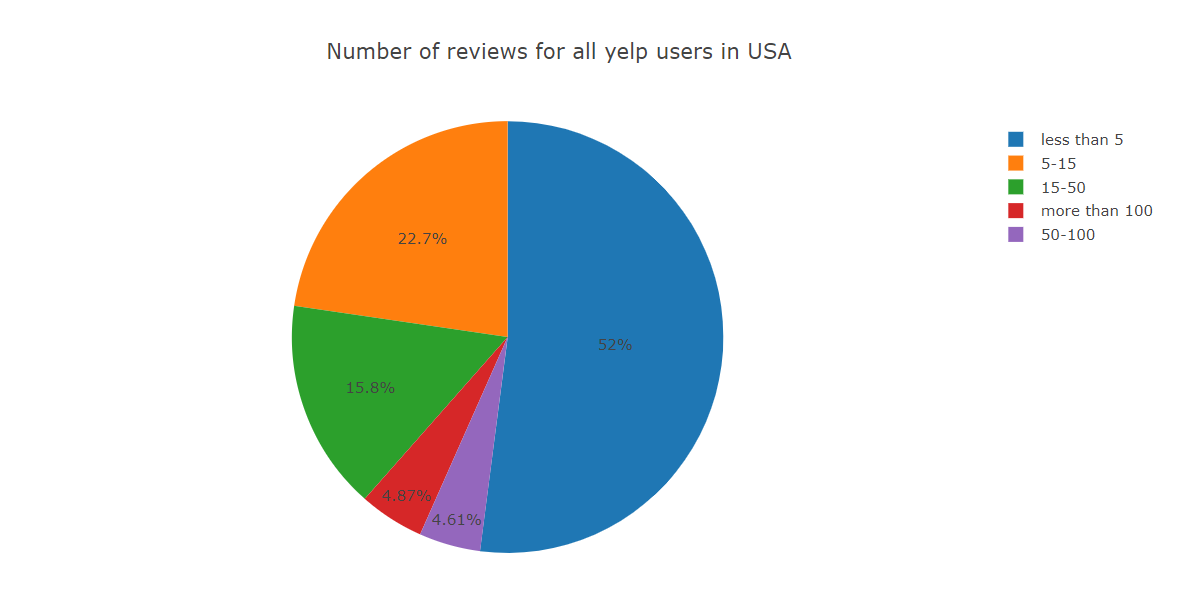

In [19]:
plt.clf()
fig = plt.figure(figsize=[8,8])
ax4=fig.add_subplot(1,1,1)
ax4.set(title = 'Number Of Reviews Users Sent',xlabel='Count of Review',ylabel='Number')
ax4.set_xlim(0,150)
# Calculate the average number of reviews users sent
ax4.axvline(reviewuser['review_count'].mean(),color='r',linestyle='dashed')
_ = ax4.hist(reviewuser['review_count'].values,bins=1000,color='lightblue',edgecolor='black',alpha=0.3)

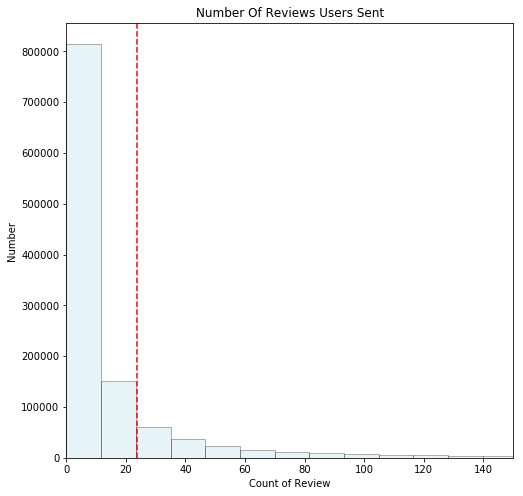

In [20]:
plt.show()

### Number of fans for all users in USA

In [23]:
fans = pd.read_sql('select id, fans from user', mydb) 

In [24]:
#prepare the count
first11 = 0  #first1 means the first segment for the pie chart.
second22 = 0
third33 = 0
forth44 = 0
#start to count
for j in range(0,1183361):
    if fans.fans[j] <= 0:
        first11 = first11 + 1
    elif fans.fans[j]  <= 5:
        second22 = second22 + 1
    elif fans.fans[j]  <= 100:
        third33 = third33 + 1
    else:
        forth44 = forth44 + 1

In [25]:
#use plotly to do offline drawing at notebook
plotly.offline.init_notebook_mode(connected=True)
#create labels and corresponding values
labels2 = ['0','0-5','5-100','more than 100']
values2 = [first11,second22,third33,forth44]
#draw the pie chart and adding layout, which in this pie chart, title is enough
trace2 = go.Pie(labels=labels2, values=values2)
layout2 = go.Layout(title='Number of fans for all yelp users in USA')
#go to the entire figure and show the plot
fig2 = go.Figure(data=[trace2], layout=layout2)
plotly.offline.iplot(fig2)

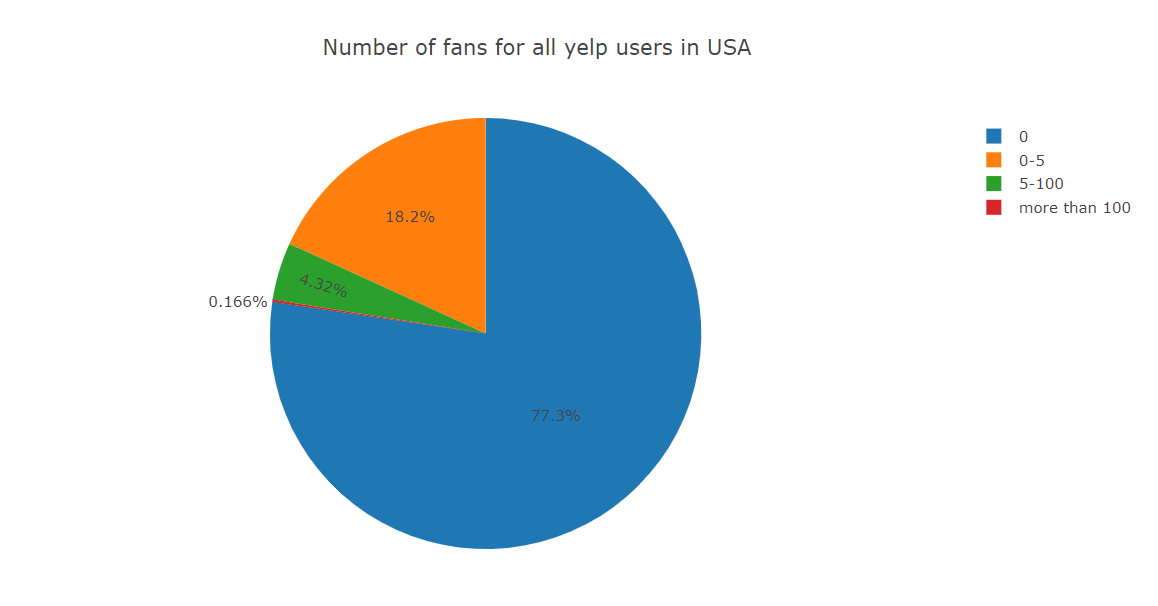

### Word Cloud of different stars

First, wordcloud package needs to be installed.

In [ ]:
!pip install wordcloud

If this command doesn't work, please go through the following steps:
* Download the .whl file compatible with your Python version and your windows distribution (32bit or 64bit) from https://www.lfd.uci.edu/~gohlke/pythonlibs/#wordcloud
* cd to the file path
* Run this command :!pip install filename

#### Word Cloud of one star

In [26]:
sql='''
    SELECT text
    FROM review
    JOIN restaurants 
    ON review.business_id = restaurants.id AND review.stars=1;
    '''

In [27]:
onestar=pd.read_sql(sql,mydb)

In [28]:
onestar.head(5)

text
0  The fact that we were able to change our reser...
1  i have to admit, i had a bad experience at thi...
2  Service was Horrible, Food was Cold, Drinks we...
3  This was by far the worst meal I have ever had...
4  My family and business associates have visited...

In [21]:
from wordcloud import WordCloud,STOPWORDS

In [25]:
#generate the total stopwords based on the given stopwords set
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("one")
stopwords.add("go")
stopwords.add("thru")
stopwords.add("also")

In [31]:
wordcloud = WordCloud(background_color="white",width=2000,height=2000,stopwords=stopwords,margin=2).generate(' '.join(onestar['text']))

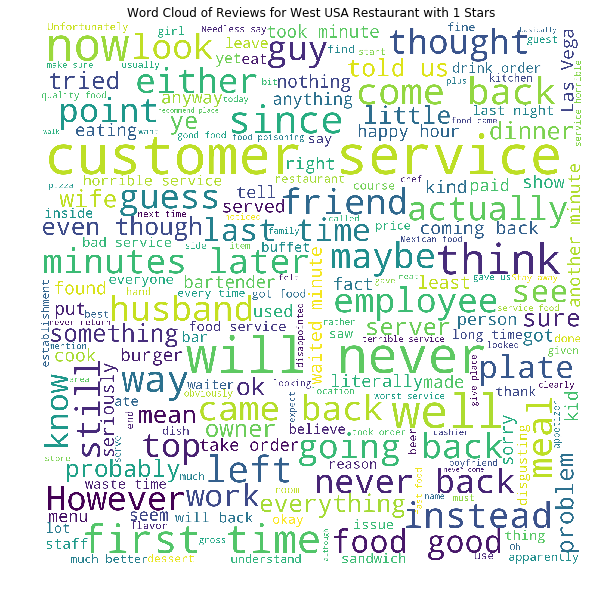

In [36]:
#display the wordcloud
plt.clf()
plt.figure(figsize=[10,10])
plt.title("Word Cloud of Reviews for West USA Restaurant with 1 Stars")
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Word Cloud of two star

In [37]:
sql='''
    SELECT text
    FROM review
    JOIN restaurants 
    ON review.business_id = restaurants.id AND review.stars=2;
    '''

In [38]:
twostar=pd.read_sql(sql,mydb)

In [39]:
len(twostar)

168116

In [40]:
wordcloud = WordCloud(background_color="white",width=2000,height=2000,stopwords=stopwords,margin=2).generate(' '.join(twostar['text']))

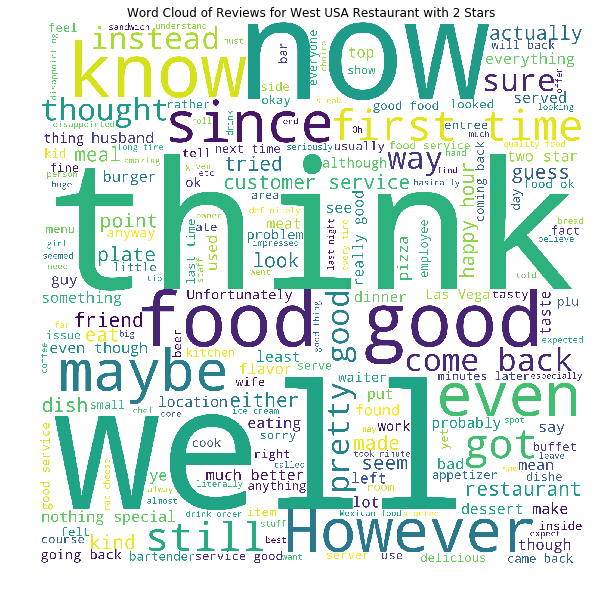

In [41]:
#display the wordcloud
plt.clf()
plt.figure(figsize=[10,10])
plt.title("Word Cloud of Reviews for West USA Restaurant with 2 Stars")
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Word Cloud of three star

In [42]:
sql='''
    SELECT text
    FROM review
    JOIN restaurants 
    ON review.business_id = restaurants.id AND review.stars=3;
    '''

In [43]:
threestar=pd.read_sql(sql,mydb)

In [44]:
wordcloud = WordCloud(background_color="white",width=2000,height=2000,stopwords=stopwords,margin=2).generate(' '.join(threestar['text']))

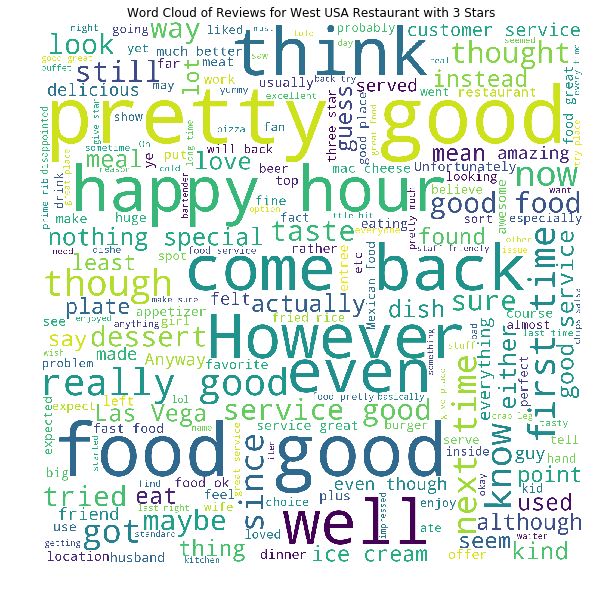

In [45]:
#display the wordcloud
plt.clf()
plt.figure(figsize=[10,10])
plt.title("Word Cloud of Reviews for West USA Restaurant with 3 Stars")
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Word Cloud of four star

In [46]:
sql='''
    SELECT text
    FROM review
    JOIN restaurants 
    ON review.business_id = restaurants.id AND review.stars=4;
    '''

In [47]:
fourstar=pd.read_sql(sql,mydb)

In [48]:
wordcloud = WordCloud(background_color="white",width=2000,height=2000,stopwords=stopwords,margin=2).generate(' '.join(fourstar['text']))

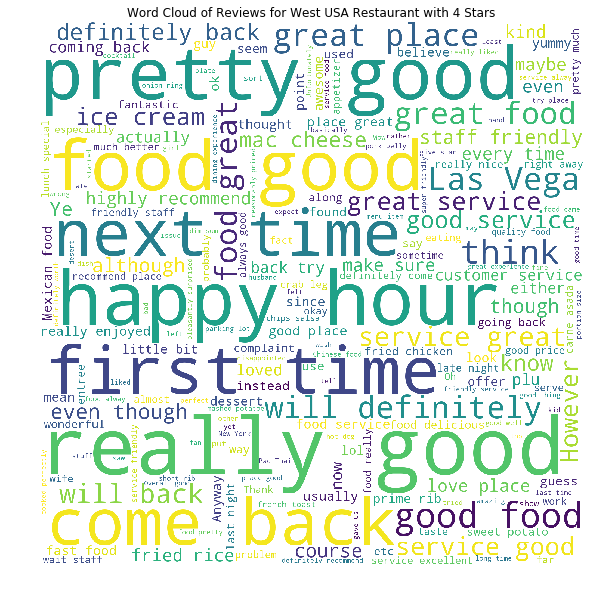

In [49]:
#display the wordcloud
plt.clf()
plt.figure(figsize=[10,10])
plt.title("Word Cloud of Reviews for West USA Restaurant with 4 Stars")
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Word Cloud of five star

In [22]:
sql='''
    SELECT text
    FROM review
    JOIN restaurants 
    ON review.business_id = restaurants.id AND review.stars=5;
    '''

In [23]:
fivestar=pd.read_sql(sql,mydb)

In [26]:
wordcloud = WordCloud(background_color="white",width=2000,height=2000,stopwords=stopwords,margin=2).generate(' '.join(fivestar['text']))

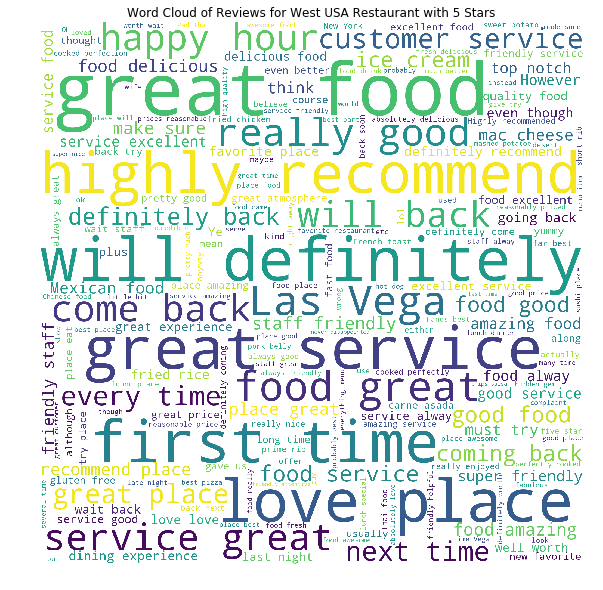

In [27]:
#display the wordcloud
plt.clf()
plt.figure(figsize=[10,10])
plt.title("Word Cloud of Reviews for West USA Restaurant with 5 Stars")
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

The wordcloud above indicates customer service plays an signficant roles in reviews of less than 2 stars. If we want to get reviews of more than 3 stars, it is essential to improve food.

### Word Cloud of Tips for West USA Restaurant with Star Less Than 2(for compared use)

In [28]:
#Select the tips which belongs to the restaurants with less than 2 stars and located in West USA from tip table. 
tiplessthan2 = pd.read_sql('select tip.text from tip, restaurants where tip.business_id = restaurants.id and restaurants.stars <= 2',mydb)

In [29]:
#Connect all the tips and save into a string called 'ti'.
ti = ' '
for i in range(0,8545,1):
    ti = ti + tiplessthan2.text[i]

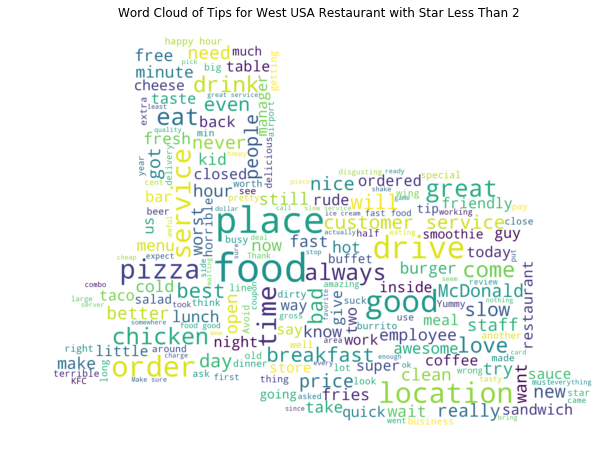

In [30]:
from os import path
from PIL import Image
import numpy as np

#We set a burger meal as the mask picture.
mask = np.array(Image.open("new1.jpg"))

#set up the background and mask figure, add the stopwords filter
#in this picture we only want to see the most frequent 200 words
wc = WordCloud(background_color="white", max_words=200,mask=mask,
               stopwords=stopwords)
# generate word cloud
wc.generate(ti)
# show the wordcloud figure and add title
plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Tips for West USA Restaurant with Star Less Than 2")
plt.show()

### Word Cloud of Tips for West USA Restaurant with Star From 2 to 4(for compared use)

In [31]:
#Select the tips which belongs to the restaurants with 2 stars to 4 stars and located in West USA from tip table. 
tip2to4 = pd.read_sql('select tip.text from tip, restaurants where tip.business_id = restaurants.id and restaurants.stars > 2 and restaurants.stars <= 4',mydb)

In [32]:
#Connect all the tips and save into a string called 'tii'.
tii = ' '
for i in range(0,379913,1):
    tii = tii + tip2to4.text[i]

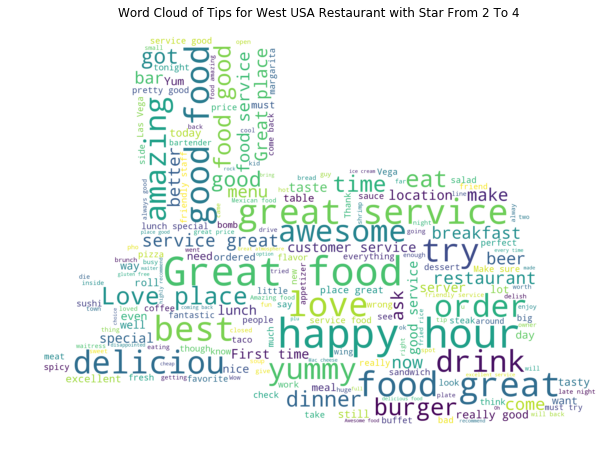

In [33]:
#set up the background and mask figure, add the stopwords filter
#in this picture we only want to see the most frequent 200 words
wc = WordCloud(background_color="white", max_words=200,mask=mask,
               stopwords=stopwords)
# generate word cloud
wc.generate(tii)
# show the wordcloud figure and add title
plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Tips for West USA Restaurant with Star From 2 To 4")
plt.show()

By comparing these two wordcloud pictures, there are some conclusions we can draw from that. 

In figure 'star 2-4', some words like 'great service', 'good food', 'happy hour' and 'food great' are the most obvious words. Some like 'best', 'love', 'try', 'delcious', 'amazing' and 'happy hour' are the second noticable words. Look even closer, it is hard to see some negative tips.

In contrast, for the figure 'star less than 2', although some of the word are the same, like 'food', 'location', 'place' and 'drive'. None of them are assciate with a positive adjective so it is hard for us to know whether these are complains or praises. Look into more details, we saw some words like 'worst', 'bad', 'never', 'wait' and 'horrible'. We inferred that some people may be unhappy about the survice and food, or get annoyed to wait for a longer time, which make a restaurant become a 2-star one.

### Word Cloud of Tips for West USA Restaurant with Star Less than 2 (for suggestion use)

In this part, we want to know what tips are given to the restaurants with star less than 2 from a suggestion view. We want to find what kind of charactors lead to complains of customers.

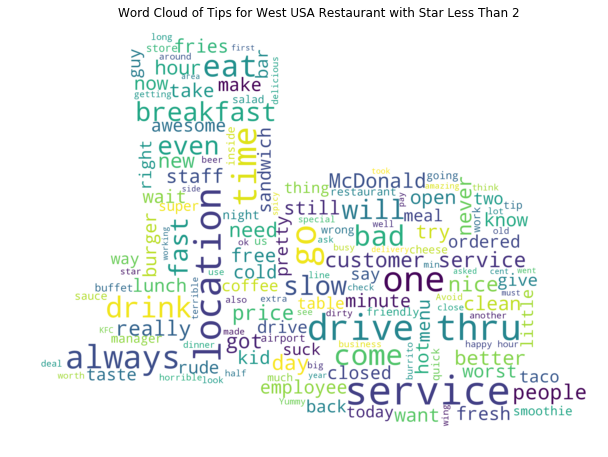

In [17]:

#add some positive wordson the given stopwords set
stopwords = set(STOPWORDS)
stopwords.add("food")
stopwords.add("good")
stopwords.add("place")
stopwords.add("order")
stopwords.add("great")
stopwords.add("chicken")
stopwords.add("pizza")
stopwords.add("love")
stopwords.add("best")
#set up the background and mask figure, add the stopwords filter
#in this picture we only want to see the most frequent 200 words
wc = WordCloud(background_color="white", max_words=150,mask=mask,
               stopwords=stopwords)
# generate word cloud
wc.generate(ti)
# show the wordcloud figure and add title
plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Tips for West USA Restaurant with Star Less Than 2")
plt.show()

About the noun words, we found customers are actually more care about service, location and drink. About the verb, we saw drive, come, taste, want and wait. About the adjective and adverbial, we saw always, bad, slow, clean, never, worst and rude. In total, our preliminary suggestions for restaurants is to find a more accessible location, improve the customer service by being polite and patient to customers and increase the responding or serving speed. What's more, make your food delicious and make the environment tidy.

### Heatmap for the busiest time weekly and daily

In this part, we want to see from monday to sunday and from morning to midnight, which period is more popular based on the checkin data in the checkin table. So the restaurant is able to forsee the potantial rush hour for a burst customer and make corresponding adjustment to the raw-material and labor-resourse.

According to the generally accepted knowledge, morning is 6:00-11:59, afternoon is 12:00-17:59, evening is 18:00-23:59, and night is 00:00-5:59.

In [34]:
#select the monday data
monday = pd.read_sql('select checkin.date from checkin,restaurants where checkin.business_id = restaurants.id and checkin.date like "Monday%"',mydb)

In [35]:
#create an empty list to contain all the time data
list11 = []
for i in monday.index:
    list11.append(monday.date[i].split('-')[1])#because the format of date is 'Monday-00:00', need to be seperated by '-'
#create an empty list to eliminate ':'.
list12 = []
for i in monday.index:
    list12.append(list11[i].replace(':',''))
#convert time to numeric is easy to compare in our case
#change the str to integer
list1 = [int(i) for i in list12]
monday['time'] = list1
#prepare to count; For example,morning1 means monday morning.
morning1 = 0
night1 = 0
evening1 = 0
afternoon1 = 0
#start to count
for i in monday.index: 
    if int(monday.time[i]) < 600 :
        night1 = night1 + 1
    elif int(monday.time[i]) < 1200:
        morning1 = morning1 + 1
    elif int(monday.time[i]) < 1800:
        afternoon1 = afternoon1 + 1
    elif int(monday.time[i]) < 2400:
        evening1 = evening1 + 1

In [36]:
#for the following cells untill the ploting one is nearly the same. 
#we need to run the cell bufore 7 times to get all data 7 days in a week
tuesday = pd.read_sql('select checkin.date from checkin,restaurants where checkin.business_id = restaurants.id and checkin.date like "Tuesday%"',mydb)

In [37]:
list21 = []
for i in tuesday.index:
    list21.append(tuesday.date[i].split('-')[1])

list22 = []
for i in tuesday.index:
    list22.append(list21[i].replace(':',''))

list2 = [int(i) for i in list22]
tuesday['time'] = list2

morning2 = 0
night2 = 0
evening2 = 0
afternoon2 = 0

for i in tuesday.index: 
    if int(tuesday.time[i]) < 600 :
        night2 = night2 + 1
    elif int(tuesday.time[i]) < 1200:
        morning2 = morning2 + 1
    elif int(tuesday.time[i]) < 1800:
        afternoon2 = afternoon2 + 1
    elif int(tuesday.time[i]) < 2400:
        evening2 = evening2 + 1

In [38]:
#wednesday
wednesday = pd.read_sql('select checkin.date from checkin,restaurants where checkin.business_id = restaurants.id and checkin.date like "Wednesday%"',mydb)

In [39]:
list31 = []
for i in wednesday.index:
    list31.append(wednesday.date[i].split('-')[1])

list32 = []
for i in wednesday.index:
    list32.append(list31[i].replace(':',''))

list3 = [int(i) for i in list32]
wednesday['time'] = list3

morning3 = 0
night3 = 0
evening3 = 0
afternoon3 = 0

for i in wednesday.index: 
    if int(wednesday.time[i]) < 600 :
        night3 = night3 + 1
    elif int(wednesday.time[i]) < 1200:
        morning3 = morning3 + 1
    elif int(wednesday.time[i]) < 1800:
        afternoon3 = afternoon3 + 1
    elif int(wednesday.time[i]) < 2400:
        evening3 = evening3 + 1


In [40]:
#thursday
thursday = pd.read_sql('select checkin.date from checkin,restaurants where checkin.business_id = restaurants.id and checkin.date like "Thursday%"',mydb)

In [41]:
list41 = []
for i in thursday.index:
    list41.append(thursday.date[i].split('-')[1])

list42 = []
for i in thursday.index:
    list42.append(list41[i].replace(':',''))

list4 = [int(i) for i in list42]
thursday['time'] = list4

morning4 = 0
night4 = 0
evening4 = 0
afternoon4 = 0

for i in thursday.index: 
    if int(thursday.time[i]) < 600 :
        night4 = night4 + 1
    elif int(thursday.time[i]) < 1200:
        morning4 = morning4 + 1
    elif int(thursday.time[i]) < 1800:
        afternoon4 = afternoon4 + 1
    elif int(thursday.time[i]) < 2400:
        evening4 = evening4 + 1

In [42]:
#friday
friday = pd.read_sql('select checkin.date from checkin,restaurants where checkin.business_id = restaurants.id and checkin.date like "Friday%"',mydb)

In [43]:
list51 = []
for i in friday.index:
    list51.append(friday.date[i].split('-')[1])

list52 = []
for i in friday.index:
    list52.append(list51[i].replace(':',''))

list5 = [int(i) for i in list52]
friday['time'] = list5

morning5 = 0
night5 = 0
evening5 = 0
afternoon5 = 0

for i in friday.index: 
    if int(friday.time[i]) < 600 :
        night5 = night5 + 1
    elif int(friday.time[i]) < 1200:
        morning5 = morning5 + 1
    elif int(friday.time[i]) < 1800:
        afternoon5 = afternoon5 + 1
    elif int(friday.time[i]) < 2400:
        evening5 = evening5 + 1

In [44]:
#saturday
saturday = pd.read_sql('select checkin.date from checkin,restaurants where checkin.business_id = restaurants.id and checkin.date like "Saturday%"',mydb)

In [45]:
list61 = []
for i in saturday.index:
    list61.append(saturday.date[i].split('-')[1])

list62 = []
for i in saturday.index:
    list62.append(list61[i].replace(':',''))

list6 = [int(i) for i in list62]
saturday['time'] = list6

morning6 = 0
night6 = 0
evening6 = 0
afternoon6 = 0

for i in saturday.index: 
    if int(saturday.time[i]) < 600 :
        night6 = night6 + 1
    elif int(saturday.time[i]) < 1200:
        morning6 = morning6 + 1
    elif int(saturday.time[i]) < 1800:
        afternoon6 = afternoon6 + 1
    elif int(saturday.time[i]) < 2400:
        evening6 = evening6 + 1

In [46]:
#sunday
sunday = pd.read_sql('select checkin.date from checkin,restaurants where checkin.business_id = restaurants.id and checkin.date like "Sunday%"',mydb)

In [47]:
list71 = []
for i in sunday.index:
    list71.append(sunday.date[i].split('-')[1])

list72 = []
for i in sunday.index:
    list72.append(list71[i].replace(':',''))

list7 = [int(i) for i in list72]
sunday['time'] = list7

morning7 = 0
night7 = 0
evening7 = 0
afternoon7 = 0

for i in sunday.index: 
    if int(sunday.time[i]) < 600 :
        night7 = night7 + 1
    elif int(sunday.time[i]) < 1200:
        morning7 = morning7 + 1
    elif int(sunday.time[i]) < 1800:
        afternoon7 = afternoon7 + 1
    elif int(sunday.time[i]) < 2400:
        evening7 = evening7 + 1

In [48]:
#put all count result into the relevant list
nightcount = [night1,night2,night3,night4,night5,night6,night7]#this means the night count from monday to sunday
morningcount = [morning1,morning2,morning3,morning4,morning5,morning6,morning7]
eveningcount = [evening1,evening2,evening3,evening4,evening5,evening6,evening7]
afternooncount = [afternoon1,afternoon2,afternoon3,afternoon4,afternoon5,afternoon6,afternoon7]

In [51]:
import plotly

plotly.offline.init_notebook_mode(connected=True)

heat = go.Heatmap(z=[morningcount,afternooncount,eveningcount,nightcount],
                   x=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'],
                   y=['Morning', 'Afternoon', 'Evening','Night'],)
data=[heat]
layout = go.Layout(title='Heatmap of Check-in Customers Weekly and Daily')
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)

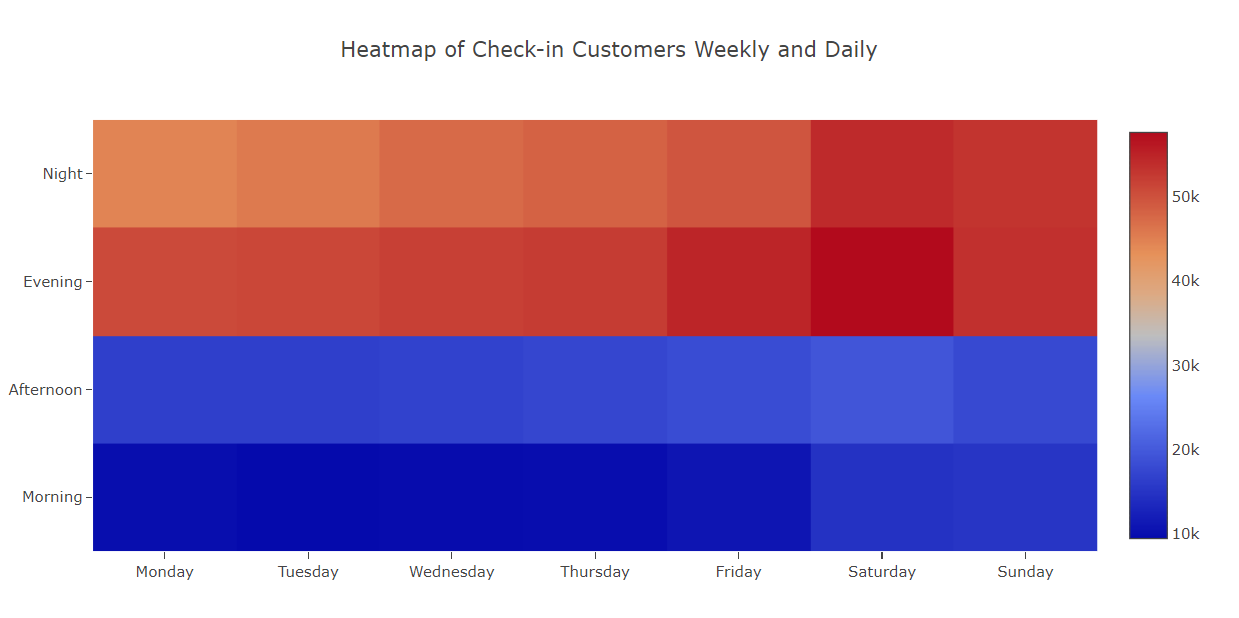

From the color bar, color heat goes up when the number of checkin people is large and goes down when that is small. It is clear that in afternoon and morning, from 6:00-17:59 in total, is less popular than evening and night, from 18:00 to 5:59 of the next day. Especially, morning is the time period that the restaurant tend to be more empty from monday to sunday. Saturday evening is the most lively time slot. 

### The relationship between location and success of business

Next, we will load data of top 50 and least 50 review count, stars and check-in count in both cities from our database.

##### Phoneix in AZ

Top 50 review_count

In [13]:
sql='''
    SELECT latitude,longitude,review_count
    FROM restaurants
    WHERE state = 'AZ' and city = 'Phoenix'
    ORDER BY review_count DESC
    LIMIT 50;
    '''

In [14]:
Top_review_AZ = pd.read_sql(sql,mydb)

In [92]:
Top_review_AZ.head()

latitude  longitude  review_count
0   33.4492   -112.066          1899
1   33.5611   -112.116          1691
2   33.5006   -112.074          1671
3   33.4550   -112.080          1602
4   33.4692   -112.047          1534

Least 50 review_count

In [15]:
sql='''
    SELECT latitude,longitude,review_count
    FROM restaurants
    WHERE state = 'AZ' and city = 'Phoenix'
    ORDER BY review_count
    LIMIT 50;
    '''

In [16]:
Lea_review_AZ = pd.read_sql(sql,mydb)

In [155]:
Lea_review_AZ.head()

latitude  longitude  review_count
0   33.5533   -112.111             3
1   33.3774   -112.071             3
2   33.4720   -112.221             3
3   33.6557   -112.012             3
4   33.7998   -112.066             3

In [17]:
import matplotlib.pyplot as plt

Top 50 stars

In [18]:
sql='''
    SELECT latitude,longitude,stars
    FROM restaurants
    WHERE state = 'AZ' and city = 'Phoenix'
    ORDER BY stars DESC
    LIMIT 50;
    '''

In [19]:
Top_stars_AZ = pd.read_sql(sql,mydb)

In [20]:
Top_stars_AZ.head()

latitude  longitude  stars
0   33.5675   -112.056    5.0
1   33.4800   -112.077    5.0
2   33.4321   -112.048    5.0
3   33.4813   -112.202    5.0
4   33.5016   -112.100    5.0

Least 50 stars

In [21]:
sql='''
    SELECT latitude,longitude,stars
    FROM restaurants
    WHERE state = 'AZ' and city = 'Phoenix'
    ORDER BY stars
    LIMIT 50;
    '''

In [22]:
Lea_stars_AZ = pd.read_sql(sql,mydb)

In [25]:
Lea_stars_AZ.head()

latitude  longitude  stars
0   33.6261   -112.014    1.0
1   33.4768   -112.220    1.0
2   33.4936   -112.169    1.0
3   33.5075   -112.040    1.0
4   33.3894   -112.134    1.0

Top 50 checkin

In [23]:
sql='''
    SELECT business_id, restaurants.latitude,restaurants.longitude,ROUND(AVG(checkin.count),2) AS checkin
    FROM checkin
    JOIN restaurants
    ON restaurants.id = checkin.business_id AND
    state = 'AZ' and city = 'Phoenix'
    GROUP BY business_id,restaurants.latitude,restaurants.longitude
    ORDER BY ROUND(AVG(checkin.count),2) DESC
    LIMIT 50;
    '''

In [24]:
Top_checkin_AZ = pd.read_sql(sql,mydb)

In [29]:
Top_checkin_AZ.head()

business_id  latitude  longitude  checkin
0  OgJ0KxwJcJ9R5bUK0ixCbg   33.5006   -112.074    70.88
1  mnwRtuVQEsIUomBchu0gwg   33.4950   -111.976    58.08
2  cTJjTKz2huGZ-ElScC2pSw   33.5136   -112.073    52.67
3  D3dAx-QW_uuClz4MambeHA   33.5023   -111.996    51.93
4  N5B7OBTyNGgwU_Y2fwNcyw   33.4558   -112.074    51.66

Least 50 checkin

In [25]:
sql='''
    SELECT business_id, restaurants.latitude,restaurants.longitude,ROUND(AVG(checkin.count),2) AS checkin
    FROM checkin
    JOIN restaurants
    ON restaurants.id = checkin.business_id AND
    state = 'AZ' and city = 'Phoenix'
    GROUP BY business_id,restaurants.latitude,restaurants.longitude
    ORDER BY ROUND(AVG(checkin.count),2)
    LIMIT 50;
    '''

In [26]:
Lea_checkin_AZ = pd.read_sql(sql,mydb)

In [32]:
Lea_checkin_AZ.head()

business_id  latitude  longitude  checkin
0  zvsJSNdg9UXEIL6FKiGa3Q   33.4960   -112.152      1.0
1  b9kQOV8VK_ecGYVoIQiHrg   33.4454   -112.067      1.0
2  uUIYh3iKyYKzbhl7ORYxVA   33.5965   -112.015      1.0
3  g-neBWSgkVEKVVUwl3iXwg   33.4951   -111.989      1.0
4  G3dMzC98ZiTdPGpynfCJTg   33.3793   -112.182      1.0

##### Las Vegas, NV

Top 50 review_count

In [27]:
sql='''
    SELECT latitude,longitude,review_count
    FROM restaurants
    WHERE state = 'NV' AND city = 'Las Vegas'
    ORDER BY review_count DESC
    LIMIT 50;
    '''

In [28]:
Top_review_NV = pd.read_sql(sql,mydb)
Top_review_NV.head()

latitude  longitude  review_count
0   36.1128   -115.173          6979
1   36.1161   -115.176          6417
2   36.1094   -115.176          5632
3   36.1107   -115.172          5429
4   36.1094   -115.172          4789

In [29]:
sql='''
    SELECT latitude,longitude,review_count
    FROM restaurants
    WHERE state = 'NV' AND city = 'Las Vegas'
    ORDER BY review_count
    LIMIT 50;
    '''

In [30]:
Lea_review_NV = pd.read_sql(sql,mydb)
Lea_review_NV.head()

latitude  longitude  review_count
0   36.2030   -115.242             3
1   36.1939   -115.192             3
2   36.0566   -115.065             3
3   36.1520   -115.244             3
4   36.2016   -115.195             3

Top 50 stars

In [31]:
sql='''
    SELECT latitude,longitude,stars
    FROM restaurants
    WHERE state = 'NV' AND city = 'Las Vegas'
    ORDER BY stars DESC
    LIMIT 50;
    '''

In [32]:
Top_stars_NV = pd.read_sql(sql,mydb)

In [109]:
Top_stars_NV.head()

latitude  longitude  stars
0   36.3065   -115.284    5.0
1   36.1586   -115.237    5.0
2   36.1017   -115.100    5.0
3   36.1148   -115.207    5.0
4   36.1040   -115.183    5.0

Least 50 stars

In [33]:
sql='''
    SELECT latitude,longitude,stars
    FROM restaurants
    WHERE state = 'NV' AND city = 'Las Vegas'
    ORDER BY stars
    LIMIT 50;
    '''

In [34]:
Lea_stars_NV = pd.read_sql(sql,mydb)

In [112]:
Lea_stars_NV.head()

latitude  longitude  stars
0   36.1464   -115.065    1.0
1   36.1360   -115.163    1.0
2   36.1807   -115.180    1.0
3   36.1145   -115.169    1.0
4   36.1977   -115.247    1.0

Top 50 checkin

In [35]:
sql='''
    SELECT business_id, restaurants.latitude,restaurants.longitude,ROUND(AVG(checkin.count),2) AS checkin
    FROM checkin
    JOIN restaurants
    ON restaurants.id = checkin.business_id AND
    state = 'NV' AND city = 'Las Vegas'
    GROUP BY business_id,restaurants.latitude,restaurants.longitude
    ORDER BY ROUND(AVG(checkin.count),2) DESC
    LIMIT 50;
    '''

In [36]:
Top_checkin_NV = pd.read_sql(sql,mydb)

In [115]:
Top_checkin_NV.head()

business_id  latitude  longitude  checkin
0  IZivKqtHyz4-ts8KsnvMrA   36.1270   -115.210   207.39
1  El4FC8jcawUVgw_0EIcbaQ   36.1022   -115.170   164.38
2  RESDUcs7fIiihp38-d6_6g   36.1161   -115.176   150.80
3  DkYS3arLOhA8si5uUEmHOw   36.1094   -115.172   147.81
4  K7lWdNUhCbcnEvI0NhGewg   36.1094   -115.176   126.80

Least 50 checkin

In [37]:
sql='''
    SELECT business_id, restaurants.latitude,restaurants.longitude,ROUND(AVG(checkin.count),2) AS checkin
    FROM checkin
    JOIN restaurants
    ON restaurants.id = checkin.business_id AND
    state = 'NV' AND city = 'Las Vegas'
    GROUP BY business_id,restaurants.latitude,restaurants.longitude
    ORDER BY ROUND(AVG(checkin.count),2)
    LIMIT 50;
    '''

In [38]:
Lea_checkin_NV = pd.read_sql(sql,mydb)

In [118]:
Lea_checkin_NV.head()

business_id  latitude  longitude  checkin
0  hV4j36jlyeBwTW_9uQiTjQ   36.0724   -115.100      1.0
1  Tnia3DIsEgc8nVPNnTRj7Q   36.1152   -115.153      1.0
2  ZEvEAMlc0YA0fFkwY96WJQ   36.1442   -115.161      1.0
3  wjkoCcNqpWrJRvCz5MxIIA   35.9997   -115.207      1.0
4  wjZ12shpUWAy4Boy0G5z1g   36.0994   -115.171      1.0

Next, we will use matplotlib to plot 6 graphs on the data we get above.

In [70]:
plt.clf()
fig = plt.figure(figsize=[10,20])
bx1=fig.add_subplot(3,2,1)
bx1.set(title = 'Review Count By Location in Phoenix AZ',xlabel='Latitude',ylabel='Longitude')
bx1.scatter(Top_review_AZ['latitude'],Top_review_AZ['longitude'],color = 'red')
bx1.scatter(Lea_review_AZ['latitude'],Lea_review_AZ['longitude'],color = 'lightblue')
bx1.legend(['Top 50','Least 50'])

In [71]:
bx2=fig.add_subplot(3,2,3)
bx2.set(title = 'Stars By Location in Phoenix AZ',xlabel='Latitude',ylabel='Longitude')
bx2.scatter(Top_stars_AZ['latitude'],Top_stars_AZ['longitude'],color = 'red')
bx2.scatter(Lea_stars_AZ['latitude'],Lea_stars_AZ['longitude'],color = 'lightblue')
bx2.legend(['Top 50','Least 50'])

In [72]:
bx3=fig.add_subplot(3,2,5)
bx3.set(title = 'Checkin By Location in Phoenix AZ',xlabel='Latitude',ylabel='Longitude')
bx3.scatter(Top_checkin_AZ['latitude'],Top_checkin_AZ['longitude'],color = 'red')
bx3.scatter(Lea_checkin_AZ['latitude'],Lea_checkin_AZ['longitude'],color = 'lightblue')
bx3.legend(['Top 50','Least 50'])

In [73]:
bx4=fig.add_subplot(3,2,2)
bx4.set(title = 'Review Count By Location in Las Vegas NV',xlabel='Latitude',ylabel='Longitude')
bx4.scatter(Top_review_NV['latitude'],Top_review_NV['longitude'],color = 'red')
bx4.scatter(Lea_review_NV['latitude'],Lea_review_NV['longitude'],color = 'lightblue')
bx4.legend(['Top 50','Least 50'])

In [74]:
bx5=fig.add_subplot(3,2,4)
bx5.set(title = 'Stars By Location in Las Vegas NV',xlabel='Latitude',ylabel='Longitude')
bx5.scatter(Top_stars_NV['latitude'],Top_stars_NV['longitude'],color = 'red')
bx5.scatter(Lea_stars_NV['latitude'],Lea_stars_NV['longitude'],color = 'lightblue')
bx5.legend(['Top 50','Least 50'])

In [75]:
bx6=fig.add_subplot(3,2,6)
bx6.set(title = 'Checkin By Location in Las Vegas NV',xlabel='Latitude',ylabel='Longitude')
bx6.scatter(Top_checkin_NV['latitude'],Top_checkin_NV['longitude'],color = 'red')
bx6.scatter(Lea_checkin_NV['latitude'],Lea_checkin_NV['longitude'],color = 'lightblue')
bx6.legend(['Top 50','Least 50'])

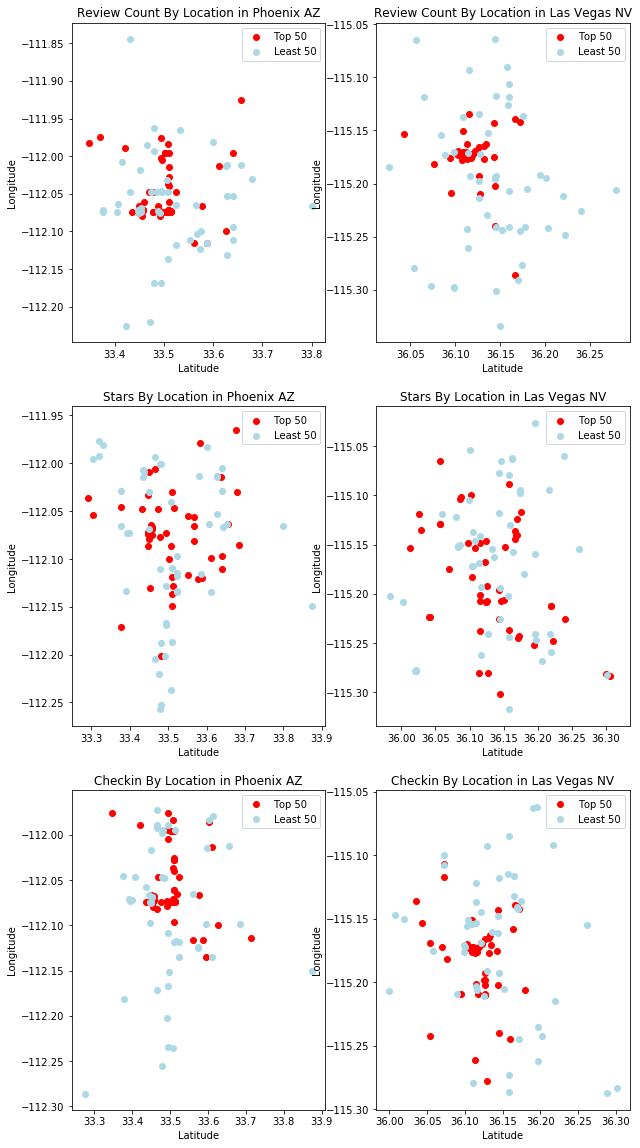

In [76]:
plt.show()

The graph above shows that restaurants of top 50 review count and checkin are usually located on some specific locations. Even so, there are restaurants of least 50 on the same locations. It may be due to other factors, like customer service or food.

### Linear Model

**Phoenix, AZ**

In [8]:
sql='''
    SELECT latitude,longitude,review_count
    FROM restaurants
    WHERE state = 'AZ' and city = 'Phoenix'
    ORDER BY review_count DESC;
    '''

In [9]:
reviewcount_AZ = pd.read_sql(sql,mydb)

In [10]:
reviewcount_AZ.head()

latitude  longitude  review_count
0   33.4492   -112.066          1899
1   33.5611   -112.116          1691
2   33.5006   -112.074          1671
3   33.4550   -112.080          1602
4   33.4692   -112.047          1534

In [11]:
reviewcount_AZ_y=reviewcount_AZ['review_count']

In [12]:
reviewcount_AZ_x = reviewcount_AZ

In [13]:
del reviewcount_AZ_x['review_count']

In [29]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

In [28]:
# Model and check its results.
X2 = sm.add_constant(reviewcount_AZ_x)
est = sm.OLS(reviewcount_AZ_y, X2)
est2 = est.fit()
print(est2.summary())

D:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:           review_count   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     23.97
Date:                Fri, 08 Dec 2017   Prob (F-statistic):           4.56e-11
Time:                        09:50:10   Log-Likelihood:                -22690.
No. Observations:                3515   AIC:                         4.539e+04
Df Residuals:                    3512   BIC:                         4.540e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.087e+04   4446.730      6.941      0.0

In [44]:
sql='''
    SELECT latitude,longitude,stars
    FROM restaurants
    WHERE state = 'AZ' and city = 'Phoenix'
    ORDER BY stars DESC;
    '''

In [46]:
stars_AZ = pd.read_sql(sql,mydb)

In [48]:
stars_AZ_y = stars_AZ['stars']

In [49]:
stars_AZ_x = stars_AZ[['latitude','longitude']]

In [50]:
X2 = sm.add_constant(stars_AZ_x)
est = sm.OLS(stars_AZ_y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     7.946
Date:                Fri, 08 Dec 2017   Prob (F-statistic):           0.000360
Time:                        10:07:37   Log-Likelihood:                -4308.0
No. Observations:                3515   AIC:                             8622.
Df Residuals:                    3512   BIC:                             8640.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         98.3713     23.819      4.130      0.0

In [73]:
sql='''
    SELECT business_id, restaurants.latitude,restaurants.longitude,ROUND(AVG(checkin.count),2) AS checkin
    FROM checkin
    JOIN restaurants
    ON restaurants.id = checkin.business_id AND
    state = 'AZ' AND city = 'Phoenix'
    GROUP BY business_id,restaurants.latitude,restaurants.longitude
    ORDER BY ROUND(AVG(checkin.count),2) DESC;
    '''

In [74]:
checkin_AZ = pd.read_sql(sql,mydb)

In [75]:
checkin_AZ_y = checkin_AZ['checkin']

In [76]:
checkin_AZ_x = checkin_AZ[['latitude','longitude']]

In [77]:
X2 = sm.add_constant(checkin_AZ_x)
est = sm.OLS(checkin_AZ_y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                checkin   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     29.26
Date:                Fri, 08 Dec 2017   Prob (F-statistic):           2.51e-13
Time:                        10:17:38   Log-Likelihood:                -10649.
No. Observations:                3389   AIC:                         2.130e+04
Df Residuals:                    3386   BIC:                         2.132e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1266.1368    165.001      7.674      0.0

** Las Vegas, NV **

In [51]:
sql='''
    SELECT latitude,longitude,review_count
    FROM restaurants
    WHERE state = 'NV' AND city = 'Las Vegas'
    ORDER BY review_count DESC;
    '''

In [52]:
reviewcount_NV = pd.read_sql(sql,mydb)

In [53]:
reviewcount_NV.head()

latitude  longitude  review_count
0   36.1128   -115.173          6979
1   36.1161   -115.176          6417
2   36.1094   -115.176          5632
3   36.1107   -115.172          5429
4   36.1094   -115.172          4789

In [54]:
reviewcount_NV_y=reviewcount_NV['review_count']

In [55]:
reviewcount_NV_x = reviewcount_NV

In [56]:
del reviewcount_NV_x['review_count']

In [57]:
X2 = sm.add_constant(reviewcount_NV_x)
est = sm.OLS(reviewcount_NV_y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           review_count   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     14.33
Date:                Fri, 08 Dec 2017   Prob (F-statistic):           6.17e-07
Time:                        10:11:16   Log-Likelihood:                -41219.
No. Observations:                5685   AIC:                         8.244e+04
Df Residuals:                    5682   BIC:                         8.246e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3545.7382   7842.234      0.452      0.6

In [58]:
sql='''
    SELECT latitude,longitude,stars
    FROM restaurants
    WHERE state = 'NV' AND city = 'Las Vegas'
    ORDER BY stars DESC;
    '''

In [59]:
stars_NV = pd.read_sql(sql,mydb)

In [60]:
stars_NV_y = stars_NV['stars']

In [61]:
stars_NV_x = stars_NV[['latitude','longitude']]

In [62]:
X2 = sm.add_constant(stars_AZ_x)
est = sm.OLS(stars_AZ_y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     7.946
Date:                Fri, 08 Dec 2017   Prob (F-statistic):           0.000360
Time:                        10:11:29   Log-Likelihood:                -4308.0
No. Observations:                3515   AIC:                             8622.
Df Residuals:                    3512   BIC:                             8640.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         98.3713     23.819      4.130      0.0

In [63]:
sql='''
    SELECT business_id, restaurants.latitude,restaurants.longitude,ROUND(AVG(checkin.count),2) AS checkin
    FROM checkin
    JOIN restaurants
    ON restaurants.id = checkin.business_id AND
    state = 'NV' AND city = 'Las Vegas'
    GROUP BY business_id,restaurants.latitude,restaurants.longitude
    ORDER BY ROUND(AVG(checkin.count),2) DESC;
    '''

In [64]:
checkin_NV = pd.read_sql(sql,mydb)

In [65]:
checkin_NV_y = checkin_NV['checkin']

In [66]:
checkin_NV_x = checkin_NV[['latitude','longitude']]

In [67]:
X2 = sm.add_constant(checkin_NV_x)
est = sm.OLS(checkin_NV_y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                checkin   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     30.49
Date:                Fri, 08 Dec 2017   Prob (F-statistic):           6.74e-14
Time:                        10:11:37   Log-Likelihood:                -20411.
No. Observations:                5535   AIC:                         4.083e+04
Df Residuals:                    5532   BIC:                         4.085e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -492.0634    226.458     -2.173      0.0

The results of linear models above shows that in Phoenix, review count and check-in count are more related to location. In both cities, stars are rarely related to location 

### Webscrapping, load data of population density

We know that location is usually related to population density. For example, some shopping malls usually located on downtwon, which attracts citizens. Therefore, we will use webscrapping to load data of population density.

** Phoenix, AZ **

In [39]:
import urllib.request
from bs4 import BeautifulSoup as bs

url = "http://zipatlas.com/us/az/phoenix/zip-code-comparison/population-density.htm"
request = urllib.request.Request(url)
response = urllib.request.urlopen(request)
data = response.read()
response.close()

# Create the soup
soup = bs(data, "html.parser")

# ---- Now we start parsing the table

bigtables = soup.findAll('div')

myLists = []

for bigtable in bigtables:
    tables = bigtable.findAll('table')
    for table in tables:
        rows = table.findAll('tr')
        r = []
        for row in rows:
            cells = row.findAll('td')
            c = []        
            for cell in cells:
                c.append(cell.getText())
            r.append(c)
        myLists.append(r)

print (myLists)

[[['Phoenix, AZ Report:', '\n\r\n\t\t\t\t\t\t\tPopulation Density\r\n\t\t\t\t\t\t\n']], [['\n\n\n\n\r\n\t\t\t\t\t\t\tshowCity();\r\n\t\t\t\t\t\t\n', '\n\n\n8,875.90\n\n\n\n\n\n\n\n34.26\n\n\n', '8,875.90', '\n\n', '34.26'], ['8,875.90'], ['\n\n'], ['34.26']], [['8,875.90'], ['\n\n'], ['34.26']], [['Related ReportsPopulation Density in Arizona by Zip CodePopulation Density in Arizona by CityPopulation Density in the United States by Zip CodePopulation Density in the United States by City#Zip CodeLocationCityPopulationPeople / Sq. MileNational Rank1.8503333.492969, -112.209757Phoenix, Arizona53,7488,875.90#6972.8501533.508664, -112.102018Phoenix, Arizona42,6968,661.01#7293.8500633.465234, -112.048771Phoenix, Arizona31,6168,085.04#8144.8501733.508782, -112.123068Phoenix, Arizona40,3857,602.47#8985.8503533.471384, -112.195259Phoenix, Arizona44,6647,551.90#9116.8501933.511534, -112.143319Phoenix, Arizona25,5877,061.64#1,0167.8503133.496009, -112.167195Phoenix, Arizona28,7316,988.32#1,0378.8

In [53]:
myLists[4]

[['#',
  'Zip Code',
  'Location',
  'City',
  'Population',
  'People / Sq. Mile',
  'National Rank'],
 ['1.',
  '85033',
  '33.492969, -112.209757',
  'Phoenix, Arizona',
  '53,748',
  '8,875.90',
  '#697'],
 ['2.',
  '85015',
  '33.508664, -112.102018',
  'Phoenix, Arizona',
  '42,696',
  '8,661.01',
  '#729'],
 ['3.',
  '85006',
  '33.465234, -112.048771',
  'Phoenix, Arizona',
  '31,616',
  '8,085.04',
  '#814'],
 ['4.',
  '85017',
  '33.508782, -112.123068',
  'Phoenix, Arizona',
  '40,385',
  '7,602.47',
  '#898'],
 ['5.',
  '85035',
  '33.471384, -112.195259',
  'Phoenix, Arizona',
  '44,664',
  '7,551.90',
  '#911'],
 ['6.',
  '85019',
  '33.511534, -112.143319',
  'Phoenix, Arizona',
  '25,587',
  '7,061.64',
  '#1,016'],
 ['7.',
  '85031',
  '33.496009, -112.167195',
  'Phoenix, Arizona',
  '28,731',
  '6,988.32',
  '#1,037'],
 ['8.',
  '85014',
  '33.508316, -112.057351',
  'Phoenix, Arizona',
  '28,516',
  '6,821.43',
  '#1,083'],
 ['9.',
  '85051',
  '33.559465, -112.1330

In [40]:
num=[]
postalcode=[]
lat=[]
lon=[]
city = []
population=[]
density=[]
nationalrank=[]

In [41]:
for i in np.arange(1,len(myLists[4])):
    for j in np.arange(len(myLists[4][i])):
        if j == 0:
            num.append(myLists[4][i][j])
        elif j == 1:
            postalcode.append(int(myLists[4][i][j]))
        elif j == 2:
            lat.append(float(myLists[4][i][j].split(",")[0]))
            lon.append(float(myLists[4][i][j].split(",")[1]))
        elif j == 3:
            city.append(myLists[4][i][j])
        elif j == 4:
            if len(myLists[4][i][j].split(",")) == 2:
                population.append(int(myLists[4][i][j].split(",")[0])*1000 + int(myLists[4][i][j].split(",")[1]))
            elif len(myLists[4][i][j].split(",")) == 1:
                population.append(int(myLists[4][i][j]))
        elif j == 5:
            if len(myLists[4][i][j].split(",")) == 2:
                density.append(float(myLists[4][i][j].split(",")[0])*1000 + float(myLists[4][i][j].split(",")[1]))
            elif len(myLists[4][i][j].split(",")) == 1:
                density.append(float(myLists[4][i][j]))
        elif j == 6:
            nationalrank.append(myLists[4][i][j])

In [42]:
density_AZ = pd.DataFrame(postalcode)

In [43]:
# Stack them as a new dataframe
density_AZ['latitude']=lat
density_AZ['longitude']=lon
density_AZ['city']='Phoenix'
density_AZ['state']='AZ'
density_AZ['population']=population
density_AZ['density']=density

In [45]:
len(density_AZ)

40

** Las Vegas, NV**

In [46]:
url = "http://zipatlas.com/us/nv/las-vegas/zip-code-comparison/population-density.htm"
request = urllib.request.Request(url)
response = urllib.request.urlopen(request)
data = response.read()
response.close()

# Create the soup
soup = bs(data, "html.parser")

# ---- Now we start parsing the table

bigtables = soup.findAll('div')

myLists = []

for bigtable in bigtables:
    tables = bigtable.findAll('table')
    for table in tables:
        rows = table.findAll('tr')
        r = []
        for row in rows:
            cells = row.findAll('td')
            c = []        
            for cell in cells:
                c.append(cell.getText())
            r.append(c)
        myLists.append(r)

print (myLists)

[[['Las Vegas, NV Report:', '\n\r\n\t\t\t\t\t\t\tPopulation Density\r\n\t\t\t\t\t\t\n']], [['\n\n\n\n\r\n\t\t\t\t\t\t\tshowCity();\r\n\t\t\t\t\t\t\n', '\n\n\n9,245.67\n\n\n\n\n\n\n\n2.92\n\n\n', '9,245.67', '\n\n', '2.92'], ['9,245.67'], ['\n\n'], ['2.92']], [['9,245.67'], ['\n\n'], ['2.92']], [['Related ReportsPopulation Density in Nevada by Zip CodePopulation Density in Nevada by CityPopulation Density in the United States by Zip CodePopulation Density in the United States by City#Zip CodeLocationCityPopulationPeople / Sq. MileNational Rank1.8910136.172765, -115.123047Las Vegas, Nevada52,6179,245.67#6612.8910836.205406, -115.223280Las Vegas, Nevada66,5587,334.55#9573.8910336.112464, -115.212086Las Vegas, Nevada46,4297,295.14#9654.8910436.151209, -115.109333Las Vegas, Nevada39,7797,052.81#1,0185.8910236.145187, -115.186547Las Vegas, Nevada37,6006,893.49#1,0646.8912836.196247, -115.263037Las Vegas, Nevada40,5386,716.57#1,1077.8912136.121616, -115.090900Las Vegas, Nevada61,6696,678.85#1

In [61]:
len(myLists)

8

In [47]:
num=[]
postalcode=[]
lat=[]
lon=[]
city = []
population=[]
density=[]
nationalrank=[]

In [48]:
for i in np.arange(1,len(myLists[4])):
    for j in np.arange(len(myLists[4][i])):
        if j == 0:
            num.append(myLists[4][i][j])
        elif j == 1:
            postalcode.append(int(myLists[4][i][j]))
        elif j == 2:
            lat.append(float(myLists[4][i][j].split(",")[0]))
            lon.append(float(myLists[4][i][j].split(",")[1]))
        elif j == 3:
            city.append(myLists[4][i][j])
        elif j == 4:
            if len(myLists[4][i][j].split(",")) == 2:
                population.append(int(myLists[4][i][j].split(",")[0])*1000 + int(myLists[4][i][j].split(",")[1]))
            elif len(myLists[4][i][j].split(",")) == 1:
                population.append(int(myLists[4][i][j]))
        elif j == 5:
            if len(myLists[4][i][j].split(",")) == 2:
                density.append(float(myLists[4][i][j].split(",")[0])*1000 + float(myLists[4][i][j].split(",")[1]))
            elif len(myLists[4][i][j].split(",")) == 1:
                density.append(float(myLists[4][i][j]))
        elif j == 6:
            nationalrank.append(myLists[4][i][j])

In [49]:
density_NV = pd.DataFrame(postalcode)

In [50]:
# Stack them as a new dataframe
density_NV['latitude']=lat
density_NV['longitude']=lon
density_NV['city']='Las Vegas'
density_NV['state']='NV'
density_NV['population']=population
density_NV['density']=density

In [67]:
len(density_NV)

36

### Using API of google's map to visualize our data 

Next, we will plot using information of population density and data from yelp.

In [52]:
from PIL import Image

In [53]:
import urllib

In [54]:
import io

In [55]:
import geocoder

In [56]:
# Source: http://www.jianshu.com/p/1abcc4595829
# The original code was based on python 2.X and I changed it into version on python 3.X
# The function to get image of map according to latitude and longitude.
def Gmap(centerLat,centerLon,zoomS,pixelS,size,dark,saveAddress):
    url = 'http://maps.googleapis.com/maps/api/staticmap?sensor=false'\
    +'&size='+str(size)+'x'+str(size)+'&center='+str(centerLat)+','\
    +str(centerLon)+'&zoom='+str(zoomS)+'&scale='+str(pixelS)\
    +'&maptype=terrain'
    if dark==True:
        url = url+'&style=feature:all|element:all|saturation:-10|lightness:20'
    buffer = io.BytesIO(urllib.request.urlopen(url).read())
    image = Image.open(buffer)
    if saveAddress:
        image.save(saveAddress)
    else:
        image.show()

#The function to convert latitude and longitude into location of pixel in the picture.
def latLonToPixelXY(lat,lon,zoomS):
    mapW = 256*2**zoomS+0.0
    mapH = 256*2**zoomS+0.0
    x = (lon+180)*(mapW/360)# get x value
    latRad = lat*np.pi/180# convert from degrees to radians
    mercN = np.log(np.tan((np.pi/4)+(latRad/2)))# get y value
    y = (mapH/2)-(mapW*mercN/(2*np.pi))
    return x,y


In [57]:
#Use geocoder to get information of latitude and longitude of Phoenix AZ. Sometimes it may not work. Please run it again.
g = geocoder.google('Phoenix AZ USA')
centerLat,centerLon = (g.lat, g.lng); scale = 11; pixelS = 2; size = 640

In [58]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(facecolor='Red', label='Top 50')
blue_patch = mpatches.Patch(facecolor='RoyalBlue', label='Least 50')
yellow_patch = mpatches.Patch(facecolor='Yellow', label='PopulationDensity')

**The code below need to use path to store image, so please define your path**

In [60]:
path = 'd:'

In [61]:
#If error happens, it should be due to the code in last cell does not work.
Gmap(centerLat,centerLon,scale,pixelS,size,True, path+'phoenix.png')

** Phoenix AZ**

Review_count

In [65]:
#If error happens, it should be due to the geocoding code does not work.
centX,centY = latLonToPixelXY(centerLat,centerLon,scale)
plt.clf()
fig = plt.figure(figsize=(10, 10))
im = np.flipud(plt.imread(path+'phoenix.png'))
ax = plt.subplot(111)
ax.imshow(im, origin='lower')

In [66]:
#Draw scatter of population density
for i in density_AZ.index:
    lat = density_AZ.loc[i,'latitude']
    lon = density_AZ.loc[i,'longitude']
    x,y = latLonToPixelXY(float(lat),float(lon),scale)
    x,y = size*pixelS/2 + x - centX,  size*pixelS/2 - (y - centY)
    ax.scatter(x,y,s=density_AZ.loc[i,'density']/50,facecolor='Yellow',lw=1,alpha=0.7,edgecolors='black')

In [67]:
#Draw scatter of top 50
for i in Top_review_AZ.index:
    lat = Top_review_AZ.loc[i,'latitude']
    lon = Top_review_AZ.loc[i,'longitude']
    x,y = latLonToPixelXY(float(lat),float(lon),scale)
    x,y = size*pixelS/2 + x - centX,  size*pixelS/2 - (y - centY)
    ax.scatter(x,y,facecolor='Red',lw=1,alpha=0.7,edgecolors='black')

In [68]:
#Draw scatter of least 50
for i in Lea_review_AZ.index:
    lat = Lea_review_AZ.loc[i,'latitude']
    lon = Lea_review_AZ.loc[i,'longitude']
    x,y = latLonToPixelXY(float(lat),float(lon),scale)
    x,y = size*pixelS/2 + x - centX,  size*pixelS/2 - (y - centY)
    ax.scatter(x,y,facecolor='RoyalBlue',lw=1,alpha=0.7,edgecolors='black')

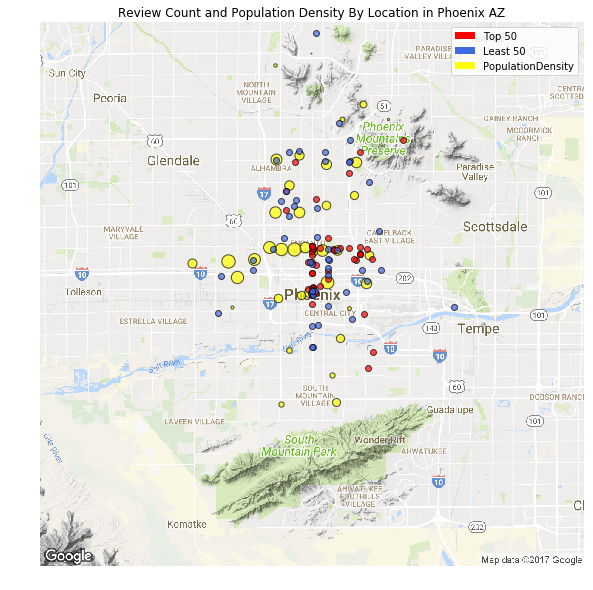

In [69]:
#Display
ax.set_xlim(0,size*pixelS)
ax.set_ylim(0,size*pixelS)
plt.legend(handles=[red_patch,blue_patch,yellow_patch])
ax.set(title = 'Review Count and Population Density By Location in Phoenix AZ')
plt.axis('off')
plt.show()

Stars

In [73]:
centX,centY = latLonToPixelXY(centerLat,centerLon,scale)
plt.clf()
fig = plt.figure(figsize=(10, 10))
im = np.flipud(plt.imread(path+'phoenix.png'))
ax = plt.subplot(111)
ax.imshow(im, origin='lower')

In [74]:
for i in density_AZ.index:
    lat = density_AZ.loc[i,'latitude']
    lon = density_AZ.loc[i,'longitude']
    x,y = latLonToPixelXY(float(lat),float(lon),scale)
    x,y = size*pixelS/2 + x - centX,  size*pixelS/2 - (y - centY)
    ax.scatter(x,y,s=density_AZ.loc[i,'density']/50,facecolor='Yellow',lw=1,alpha=0.7,edgecolors='black')

In [75]:
for i in Top_stars_AZ.index:
    lat = Top_stars_AZ.loc[i,'latitude']
    lon = Top_stars_AZ.loc[i,'longitude']
    x,y = latLonToPixelXY(float(lat),float(lon),scale)
    x,y = size*pixelS/2 + x - centX,  size*pixelS/2 - (y - centY)
    ax.scatter(x,y,facecolor='Red',lw=1,alpha=0.7,edgecolors='black')

In [76]:
for i in Lea_stars_AZ.index:
    lat = Lea_stars_AZ.loc[i,'latitude']
    lon = Lea_stars_AZ.loc[i,'longitude']
    x,y = latLonToPixelXY(float(lat),float(lon),scale)
    x,y = size*pixelS/2 + x - centX,  size*pixelS/2 - (y - centY)
    ax.scatter(x,y,facecolor='RoyalBlue',lw=1,alpha=0.7,edgecolors='black')

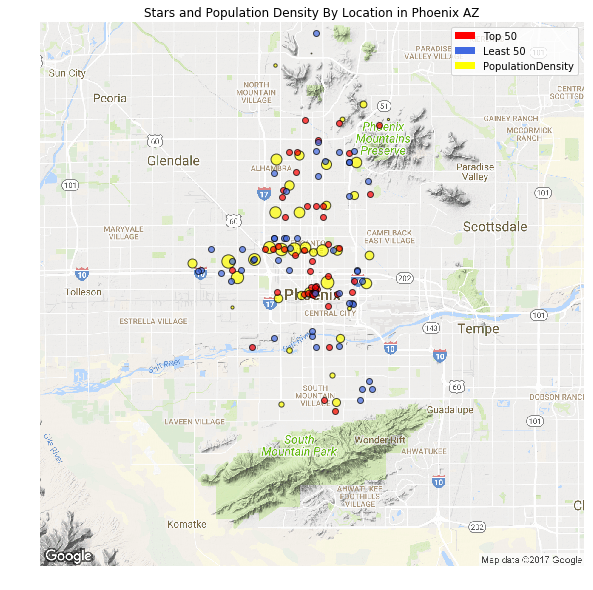

In [77]:
ax.set_xlim(0,size*pixelS)
ax.set_ylim(0,size*pixelS)
plt.legend(handles=[red_patch,blue_patch,yellow_patch])
ax.set(title = 'Stars and Population Density By Location in Phoenix AZ')
plt.axis('off')
plt.show()

Check in

In [78]:
centX,centY = latLonToPixelXY(centerLat,centerLon,scale)
fig = plt.figure(figsize=(10, 10))
im = np.flipud(plt.imread(path+'phoenix.png'))
ax = plt.subplot(111)
ax.imshow(im, origin='lower')

In [79]:
for i in density_AZ.index:
    lat = density_AZ.loc[i,'latitude']
    lon = density_AZ.loc[i,'longitude']
    x,y = latLonToPixelXY(float(lat),float(lon),scale)
    x,y = size*pixelS/2 + x - centX,  size*pixelS/2 - (y - centY)
    ax.scatter(x,y,s=density_AZ.loc[i,'density']/50,facecolor='Yellow',lw=1,alpha=0.7,edgecolors='black')

In [80]:
for i in Top_checkin_AZ.index:
    lat = Top_checkin_AZ.loc[i,'latitude']
    lon = Top_checkin_AZ.loc[i,'longitude']
    x,y = latLonToPixelXY(float(lat),float(lon),scale)
    x,y = size*pixelS/2 + x - centX,  size*pixelS/2 - (y - centY)
    ax.scatter(x,y,facecolor='Red',lw=1,alpha=0.7,edgecolors='black')

In [81]:
for i in Lea_checkin_AZ.index:
    lat = Lea_checkin_AZ.loc[i,'latitude']
    lon = Lea_checkin_AZ.loc[i,'longitude']
    x,y = latLonToPixelXY(float(lat),float(lon),scale)
    x,y = size*pixelS/2 + x - centX,  size*pixelS/2 - (y - centY)
    ax.scatter(x,y,facecolor='RoyalBlue',lw=1,alpha=0.7,edgecolors='black')

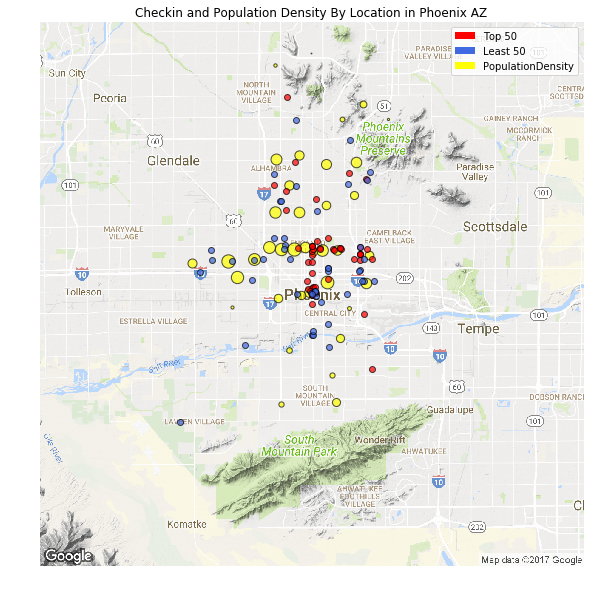

In [82]:
ax.set_xlim(0,size*pixelS)
ax.set_ylim(0,size*pixelS)
plt.legend(handles=[red_patch,blue_patch,yellow_patch])
ax.set(title = 'Checkin and Population Density By Location in Phoenix AZ')
plt.axis('off')
plt.show()

**Las Vegas NV**

In [83]:
#Use geocoder to get information of latitude and longitude of Phoenix AZ. Sometimes it may not work. Please run it again.
g = geocoder.google('Las Vegas NV USA')
centerLat,centerLon = (g.lat, g.lng); scale = 11; pixelS = 2; size = 640

In [84]:
#If error happens, it should be due to the code in last cell does not work.
Gmap(centerLat,centerLon,scale,pixelS,size,True, path+'lasvegas.png')

Review_count

In [85]:
#If error happens, it should be due to the geocoding code does not work.
centX,centY = latLonToPixelXY(centerLat,centerLon,scale)
fig = plt.figure(figsize=(10, 10))
im = np.flipud(plt.imread(path+'lasvegas.png'))
ax = plt.subplot(111)
ax.imshow(im, origin='lower')

In [86]:
for i in density_NV.index:
    lat = density_NV.loc[i,'latitude']
    lon = density_NV.loc[i,'longitude']
    x,y = latLonToPixelXY(float(lat),float(lon),scale)
    x,y = size*pixelS/2 + x - centX,  size*pixelS/2 - (y - centY)
    ax.scatter(x,y,s=density_NV.loc[i,'density']/50,facecolor='Yellow',lw=1,alpha=0.7,edgecolors='black')

In [87]:
for i in Top_review_NV.index:
    lat = Top_review_NV.loc[i,'latitude']
    lon = Top_review_NV.loc[i,'longitude']
    x,y = latLonToPixelXY(float(lat),float(lon),scale)
    x,y = size*pixelS/2 + x - centX,  size*pixelS/2 - (y - centY)
    ax.scatter(x,y,facecolor='Red',lw=1,alpha=0.7,edgecolors='black')

In [88]:
for i in Lea_review_NV.index:
    lat = Lea_review_NV.loc[i,'latitude']
    lon = Lea_review_NV.loc[i,'longitude']
    x,y = latLonToPixelXY(float(lat),float(lon),scale)
    x,y = size*pixelS/2 + x - centX,  size*pixelS/2 - (y - centY)
    ax.scatter(x,y,facecolor='RoyalBlue',lw=1,alpha=0.7,edgecolors='black')

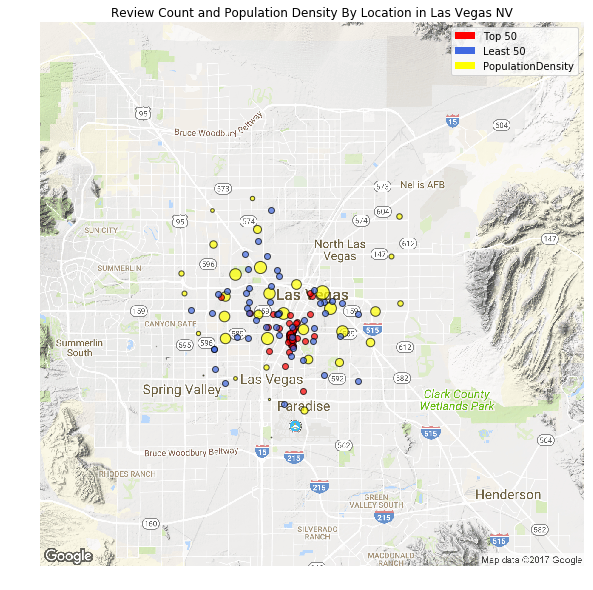

In [89]:
ax.set_xlim(0,size*pixelS)
ax.set_ylim(0,size*pixelS)
plt.legend(handles=[red_patch,blue_patch,yellow_patch])
ax.set(title = 'Review Count and Population Density By Location in Las Vegas NV')
plt.axis('off')
plt.show()

Stars

In [90]:
centX,centY = latLonToPixelXY(centerLat,centerLon,scale)
fig = plt.figure(figsize=(10, 10))
im = np.flipud(plt.imread(path+'lasvegas.png'))
ax = plt.subplot(111)
ax.imshow(im, origin='lower')

In [91]:
for i in density_NV.index:
    lat = density_NV.loc[i,'latitude']
    lon = density_NV.loc[i,'longitude']
    x,y = latLonToPixelXY(float(lat),float(lon),scale)
    x,y = size*pixelS/2 + x - centX,  size*pixelS/2 - (y - centY)
    ax.scatter(x,y,s=density_NV.loc[i,'density']/50,facecolor='Yellow',lw=1,alpha=0.7,edgecolors='black')

In [92]:
for i in Top_stars_NV.index:
    lat = Top_stars_NV.loc[i,'latitude']
    lon = Top_stars_NV.loc[i,'longitude']
    x,y = latLonToPixelXY(float(lat),float(lon),scale)
    x,y = size*pixelS/2 + x - centX,  size*pixelS/2 - (y - centY)
    ax.scatter(x,y,facecolor='Red',lw=1,alpha=0.7,edgecolors='black')

In [93]:
for i in Lea_stars_NV.index:
    lat = Lea_stars_NV.loc[i,'latitude']
    lon = Lea_stars_NV.loc[i,'longitude']
    x,y = latLonToPixelXY(float(lat),float(lon),scale)
    x,y = size*pixelS/2 + x - centX,  size*pixelS/2 - (y - centY)
    ax.scatter(x,y,facecolor='RoyalBlue',lw=1,alpha=0.7,edgecolors='black')

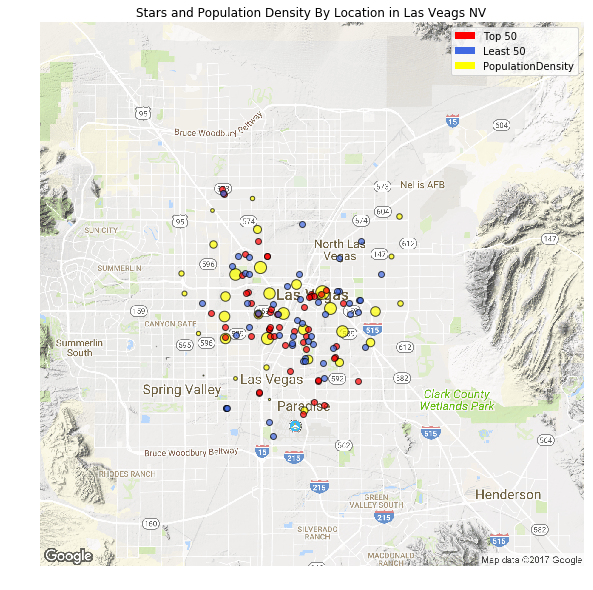

In [94]:
ax.set_xlim(0,size*pixelS)
ax.set_ylim(0,size*pixelS)
plt.legend(handles=[red_patch,blue_patch,yellow_patch])
ax.set(title = 'Stars and Population Density By Location in Las Veags NV')
plt.axis('off')
plt.show()

Check in

In [103]:
centX,centY = latLonToPixelXY(centerLat,centerLon,scale)
fig = plt.figure(figsize=(10, 10))
im = np.flipud(plt.imread(path+'lasvegas.png'))
ax = plt.subplot(111)
ax.imshow(im, origin='lower')

In [104]:
for i in density_NV.index:
    lat = density_NV.loc[i,'latitude']
    lon = density_NV.loc[i,'longitude']
    x,y = latLonToPixelXY(float(lat),float(lon),scale)
    x,y = size*pixelS/2 + x - centX,  size*pixelS/2 - (y - centY)
    ax.scatter(x,y,s=density_NV.loc[i,'density']/50,facecolor='Yellow',lw=1,alpha=0.7,edgecolors='black')

In [105]:
for i in Top_checkin_NV.index:
    lat = Top_checkin_NV.loc[i,'latitude']
    lon = Top_checkin_NV.loc[i,'longitude']
    x,y = latLonToPixelXY(float(lat),float(lon),scale)
    x,y = size*pixelS/2 + x - centX,  size*pixelS/2 - (y - centY)
    ax.scatter(x,y,facecolor='Red',lw=1,alpha=0.7,edgecolors='black')

In [106]:
for i in Lea_checkin_NV.index:
    lat = Lea_checkin_NV.loc[i,'latitude']
    lon = Lea_checkin_NV.loc[i,'longitude']
    x,y = latLonToPixelXY(float(lat),float(lon),scale)
    x,y = size*pixelS/2 + x - centX,  size*pixelS/2 - (y - centY)
    ax.scatter(x,y,facecolor='RoyalBlue',lw=1,alpha=0.7,edgecolors='black')

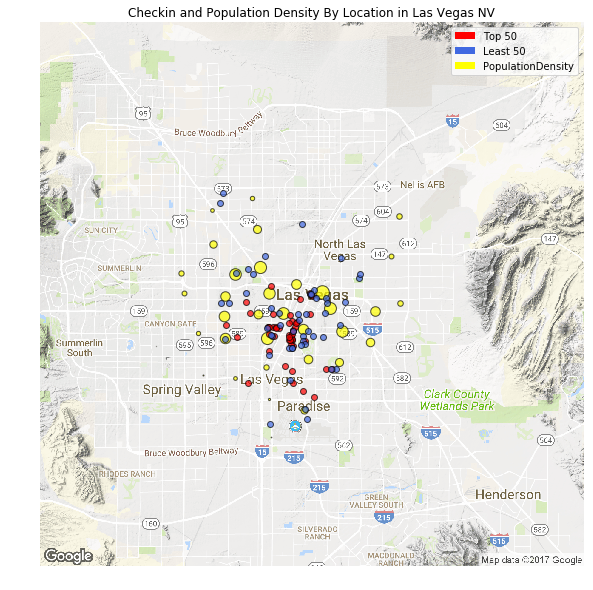

In [107]:
ax.set_xlim(0,size*pixelS)
ax.set_ylim(0,size*pixelS)
plt.legend(handles=[red_patch,blue_patch,yellow_patch])
ax.set(title = 'Checkin and Population Density By Location in Las Vegas NV')
plt.axis('off')
plt.show()

### Regression Model

In [311]:
from pandas.io.json import json_normalize
import json

In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [313]:
fn = 'c:/business.json'

In [314]:
s=[]
for line in open(fn, 'r'):
    s.append(json.loads(line))

In [315]:
len(s)

156639

In [316]:
s[0]

{'address': '691 Richmond Rd',
 'attributes': {'BikeParking': True,
  'BusinessParking': {'garage': False,
   'lot': True,
   'street': False,
   'valet': False,
   'validated': False},
  'RestaurantsPriceRange2': 2,
  'WheelchairAccessible': True},
 'business_id': 'YDf95gJZaq05wvo7hTQbbQ',
 'categories': ['Shopping', 'Shopping Centers'],
 'city': 'Richmond Heights',
 'hours': {'Friday': '10:00-21:00',
  'Monday': '10:00-21:00',
  'Saturday': '10:00-21:00',
  'Sunday': '11:00-18:00',
  'Thursday': '10:00-21:00',
  'Tuesday': '10:00-21:00',
  'Wednesday': '10:00-21:00'},
 'is_open': 1,
 'latitude': 41.5417162,
 'longitude': -81.4931165,
 'name': 'Richmond Town Square',
 'neighborhood': '',
 'postal_code': '44143',
 'review_count': 17,
 'stars': 2.0,
 'state': 'OH'}

In [317]:
df1 = pd.DataFrame.from_dict(json_normalize(s), orient='columns')

In [318]:
df1.head(5)

address attributes.AcceptsInsurance  \
0                      691 Richmond Rd                         NaN   
1                       2824 Milton Rd                         NaN   
2                  337 Danforth Avenue                         NaN   
3  7702 E Doubletree Ranch Rd, Ste 300                         NaN   
4                       4719 N 20Th St                         NaN   

  attributes.AgesAllowed attributes.Alcohol attributes.Ambience.casual  \
0                    NaN                NaN                        NaN   
1                    NaN                NaN                      False   
2                    NaN                NaN                        NaN   
3                    NaN                NaN                        NaN   
4                    NaN               none                      False   

  attributes.Ambience.classy attributes.Ambience.divey  \
0                        NaN                       NaN   
1                      False                     False   
2                        NaN                       NaN   
3                        NaN                       NaN   
4                      False                     False   

  attributes.Ambience.hipster attributes.Ambience.intimate  \
0                         NaN                          NaN   
1                       False                        False   
2                         NaN                          NaN   
3                         NaN                          NaN   
4                       False                        False   

  attributes.Ambience.romantic  ...  hours.Wednesday is_open   latitude  \
0                          NaN  ...      10:00-21:00       1  41.541716   
1                        False  ...      10:00-22:00       0  35.236870   
2                          NaN  ...      10:00-19:00       0  43.677126   
3                          NaN  ...       9:00-17:00       1  33.565082   
4                        False  ...              NaN       0  33.505928   

    longitude                                name neighborhood postal_code  \
0  -81.493116                Richmond Town Square                    44143   
1  -80.741976  South Florida Style Chicken & Ribs     Eastland       28215   
2  -79.353285                    The Tea Emporium    Riverdale     M4K 1N7   
3 -111.916400                            TRUmatch                    85258   
4 -112.038847                             Blimpie                    85016   

  review_count stars state  
0           17   2.0    OH  
1            4   4.5    NC  
2            7   4.5    ON  
3            3   3.0    AZ  
4           10   4.5    AZ  

[5 rows x 101 columns]

In [319]:
df2=df1.dropna(axis=1,thresh=39159)

In [320]:
df2.head()

address attributes.Alcohol  \
0                      691 Richmond Rd                NaN   
1                       2824 Milton Rd                NaN   
2                  337 Danforth Avenue                NaN   
3  7702 E Doubletree Ranch Rd, Ste 300                NaN   
4                       4719 N 20Th St               none   

  attributes.Ambience.casual attributes.Ambience.classy  \
0                        NaN                        NaN   
1                      False                      False   
2                        NaN                        NaN   
3                        NaN                        NaN   
4                      False                      False   

  attributes.Ambience.hipster attributes.Ambience.intimate  \
0                         NaN                          NaN   
1                       False                        False   
2                         NaN                          NaN   
3                         NaN                          NaN   
4                       False                        False   

  attributes.Ambience.romantic attributes.Ambience.touristy  \
0                          NaN                          NaN   
1                        False                        False   
2                          NaN                          NaN   
3                          NaN                          NaN   
4                        False                        False   

  attributes.Ambience.trendy attributes.Ambience.upscale  ...   \
0                        NaN                         NaN  ...    
1                      False                       False  ...    
2                        NaN                         NaN  ...    
3                        NaN                         NaN  ...    
4                      False                       False  ...    

  hours.Wednesday is_open   latitude   longitude  \
0     10:00-21:00       1  41.541716  -81.493116   
1     10:00-22:00       0  35.236870  -80.741976   
2     10:00-19:00       0  43.677126  -79.353285   
3      9:00-17:00       1  33.565082 -111.916400   
4             NaN       0  33.505928 -112.038847   

                                 name neighborhood postal_code review_count  \
0                Richmond Town Square                    44143           17   
1  South Florida Style Chicken & Ribs     Eastland       28215            4   
2                    The Tea Emporium    Riverdale     M4K 1N7            7   
3                            TRUmatch                    85258            3   
4                             Blimpie                    85016           10   

  stars state  
0   2.0    OH  
1   4.5    NC  
2   4.5    ON  
3   3.0    AZ  
4   4.5    AZ  

[5 rows x 55 columns]

In [321]:
del df2["address"]
del df2["business_id"]
del df2["categories"]
del df2["city"]
del df2["hours.Friday"]
del df2["hours.Monday"]
del df2["hours.Saturday"]
del df2["hours.Sunday"]
del df2["hours.Thursday"]
del df2["hours.Tuesday"]
del df2["hours.Wednesday"]
del df2["is_open"]
del df2["latitude"]
del df2["longitude"]
del df2["name"]
del df2["neighborhood"]
del df2["postal_code"]
del df2["state"]

In [322]:
df2.head()

attributes.Alcohol attributes.Ambience.casual attributes.Ambience.classy  \
0                NaN                        NaN                        NaN   
1                NaN                      False                      False   
2                NaN                        NaN                        NaN   
3                NaN                        NaN                        NaN   
4               none                      False                      False   

  attributes.Ambience.hipster attributes.Ambience.intimate  \
0                         NaN                          NaN   
1                       False                        False   
2                         NaN                          NaN   
3                         NaN                          NaN   
4                       False                        False   

  attributes.Ambience.romantic attributes.Ambience.touristy  \
0                          NaN                          NaN   
1                        False                        False   
2                          NaN                          NaN   
3                          NaN                          NaN   
4                        False                        False   

  attributes.Ambience.trendy attributes.Ambience.upscale  \
0                        NaN                         NaN   
1                      False                       False   
2                        NaN                         NaN   
3                        NaN                         NaN   
4                      False                       False   

  attributes.BikeParking  ...  attributes.RestaurantsDelivery  \
0                   True  ...                             NaN   
1                    NaN  ...                            True   
2                   True  ...                             NaN   
3                    NaN  ...                             NaN   
4                   True  ...                           False   

  attributes.RestaurantsGoodForGroups attributes.RestaurantsPriceRange2  \
0                                 NaN                               2.0   
1                                True                               2.0   
2                                 NaN                               2.0   
3                                 NaN                               NaN   
4                                True                               1.0   

  attributes.RestaurantsReservations attributes.RestaurantsTableService  \
0                                NaN                                NaN   
1                              False                                NaN   
2                                NaN                                NaN   
3                                NaN                                NaN   
4                              False                              False   

  attributes.RestaurantsTakeOut attributes.WheelchairAccessible  \
0                           NaN                            True   
1                          True                             NaN   
2                           NaN                            True   
3                           NaN                             NaN   
4                          True                             NaN   

  attributes.WiFi review_count stars  
0             NaN           17   2.0  
1             NaN            4   4.5  
2              no            7   4.5  
3             NaN            3   3.0  
4              no           10   4.5  

[5 rows x 37 columns]

In [323]:
df3=df2.dropna(thresh=18)

In [324]:
df3.head()

attributes.Alcohol attributes.Ambience.casual attributes.Ambience.classy  \
1                 NaN                      False                      False   
4                none                      False                      False   
14           full_bar                      False                      False   
21               none                      False                      False   
25           full_bar                      False                      False   

   attributes.Ambience.hipster attributes.Ambience.intimate  \
1                        False                        False   
4                        False                        False   
14                       False                        False   
21                       False                        False   
25                       False                        False   

   attributes.Ambience.romantic attributes.Ambience.touristy  \
1                         False                        False   
4                         False                        False   
14                        False                        False   
21                        False                        False   
25                        False                        False   

   attributes.Ambience.trendy attributes.Ambience.upscale  \
1                       False                       False   
4                       False                       False   
14                      False                       False   
21                      False                       False   
25                      False                       False   

   attributes.BikeParking  ...  attributes.RestaurantsDelivery  \
1                     NaN  ...                            True   
4                    True  ...                           False   
14                   True  ...                           False   
21                   True  ...                           False   
25                   True  ...                             NaN   

   attributes.RestaurantsGoodForGroups attributes.RestaurantsPriceRange2  \
1                                 True                               2.0   
4                                 True                               1.0   
14                                True                               2.0   
21                               False                               1.0   
25                                True                               2.0   

   attributes.RestaurantsReservations attributes.RestaurantsTableService  \
1                               False                                NaN   
4                               False                              False   
14                              False                              False   
21                              False                               True   
25                                NaN                                NaN   

   attributes.RestaurantsTakeOut attributes.WheelchairAccessible  \
1                           True                             NaN   
4                           True                             NaN   
14                          True                             NaN   
21                          True                             NaN   
25                           NaN                           False   

   attributes.WiFi review_count stars  
1              NaN            4   4.5  
4               no           10   4.5  
14            free           21   2.0  
21              no           15   3.0  
25             NaN           14   4.0  

[5 rows x 37 columns]

In [325]:
#find Number of nan in every attributes
from __future__ import division
print (df3.shape)
df3.isnull().sum(axis=0)/df3.shape[0]
#results show a lot of nan value

(46943, 37)


attributes.Alcohol                       0.098843
attributes.Ambience.casual               0.096564
attributes.Ambience.classy               0.096564
attributes.Ambience.hipster              0.097033
attributes.Ambience.intimate             0.096564
attributes.Ambience.romantic             0.096564
attributes.Ambience.touristy             0.096564
attributes.Ambience.trendy               0.096564
attributes.Ambience.upscale              0.096564
attributes.BikeParking                   0.231004
attributes.BusinessAcceptsCreditCards    0.050913
attributes.BusinessParking.garage        0.091877
attributes.BusinessParking.lot           0.091877
attributes.BusinessParking.street        0.091877
attributes.BusinessParking.valet         0.091877
attributes.BusinessParking.validated     0.115118
attributes.GoodForKids                   0.089215
attributes.GoodForMeal.breakfast         0.110517
attributes.GoodForMeal.brunch            0.110517
attributes.GoodForMeal.dessert           0.110517


In [326]:
from sklearn.preprocessing import LabelEncoder

#use -1 to make missing value a separate category
df3.fillna(-1, inplace=True)

le = LabelEncoder()
for col in df3.columns:
    df3.loc[:, col] = le.fit_transform(df3.loc[:, col].astype(str))

C:\Anaconda\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [327]:
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn import linear_model, ensemble

skf = StratifiedKFold(n_splits=3)

rfc = ensemble.RandomForestClassifier(n_estimators=100, criterion='entropy', 
                                      max_depth=None, min_samples_split=2, 
                                      min_samples_leaf=4, 
                                      min_weight_fraction_leaf=0.0, 
                                      max_features='auto', 
                                      max_leaf_nodes=None, 
                                      bootstrap=True, 
                                      oob_score=False, 
                                      n_jobs=1)

for train_index, test_index in skf.split(df3.iloc[:, :-1], 
                le.fit_transform(df3.iloc[:, -1])):
    rfc.fit(df3.iloc[train_index, :-1], 
            df3.iloc[train_index, -1])
    print (rfc.score(df3.iloc[test_index, :-1], 
            df3.iloc[test_index, -1]))

0.297022744697
0.30029396728
0.294700505018


<Container object of 36 artists>

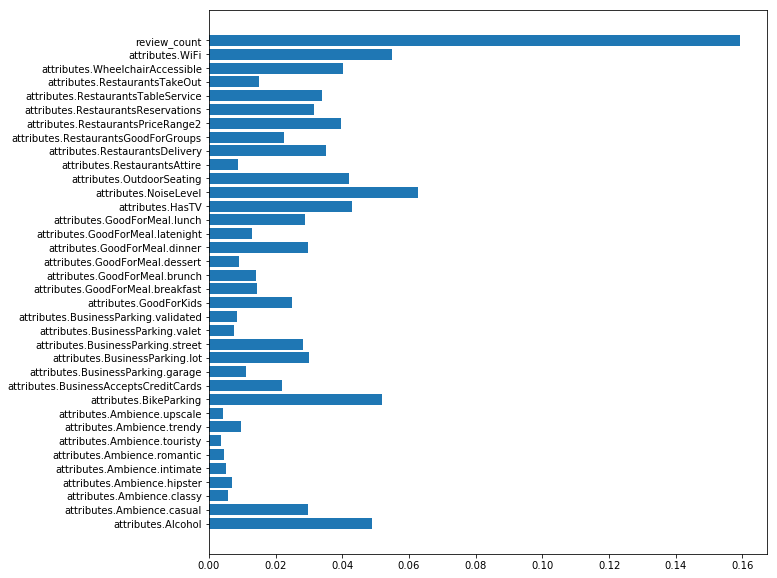

In [331]:
fig = plt.figure(figsize=(10,10))
plt.barh(range(df3.shape[1]-1) ,rfc.feature_importances_,
        tick_label=df3.columns[:-1])

The result above shows that the Wifi, Noise Level, Bike Parking and alcohol are important factors.